### Thesis ADS: Rosa Lucassen

# Loading the data

In [3]:
import pickle
import pandas as pd
import numpy as np
from numpy import array

import spacy
import stop_words
nlp = spacy.load("en_core_web_sm")
nlp.vocab["covid"].is_stop = True
nlp.vocab["corona"].is_stop = True
nlp.vocab["covid19"].is_stop = True
nlp.vocab["covid-19"].is_stop = True
nlp.vocab["coronavirus"].is_stop = True

import re
import emoji
from collections import Counter
from scipy.stats import chi2_contingency
from urllib.parse import urlparse
from nltk.stem.porter import PorterStemmer

import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

import logging
import pyLDAvis.gensim
import json

import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
stemmer = PorterStemmer()

# Function: Cleaning data

In [4]:
def remove_single_char(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def remove_numbers(text):
    number_pattern = r'\b(?<![0-9-])(\d+)(?![0-9-])'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number


def remove_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    without_urls = re.sub(pattern=url_pattern, repl=" ", string=text)
    return without_urls


def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    without_emoji = emoji_pattern.sub(r'',text)
    return without_emoji

def remove_nonalpha(text):
    nonalpha_pattern = "[+$@#?~]"
    without_nonalpha = re.sub(pattern=nonalpha_pattern, repl=" ", string=text)
    return without_nonalpha
    
def remove_rt(text):
    rt_pattern = 'rt @[\w_]+: '
    without_pattern = re.sub(pattern = rt_pattern, repl=" ", string = text)
    return without_pattern 

def remove_extra_spaces(text):
    space_pattern = r'\s+'
    without_space = re.sub(pattern=space_pattern, repl=" ", string=text)
    return without_space

def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

# Function: BiGrams

In [5]:
from gensim.models import Phrases
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

# Function: Lemmatizing texts

In [9]:
def pre_processer_real(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)
    
    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_real = flatten(tokenized_texts)
    counts = Counter(flat_real)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flat_real, tokenized_texts

def pre_processer_fake(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)

    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_fake = flatten(tokenized_texts)
    counts = Counter(flat_fake)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flat_fake, tokenized_texts

# Function: distinctive words

In [5]:
def distinctive_words(target_corpus, reference_corpus):
    counts_c1 = Counter(target_corpus) # don't forget to flatten your texts!
    counts_c2 = Counter(reference_corpus)
    vocabulary = set(list(counts_c1.keys()) + list(counts_c2.keys()))
    freq_c1_total = sum(counts_c1.values()) 
    freq_c2_total = sum(counts_c2.values()) 
    results = []
    for word in vocabulary:
        freq_c1 = counts_c1[word]
        freq_c2 = counts_c2[word]
        freq_c1_other = freq_c1_total - freq_c1
        freq_c2_other = freq_c2_total - freq_c2
        llr, p_value,_,_ = chi2_contingency([[freq_c1, freq_c2], 
                      [freq_c1_other, freq_c2_other]],
                      lambda_='log-likelihood') 
        if freq_c2 / freq_c2_other > freq_c1 / freq_c1_other:
            llr = -llr
        result = {'word':word, 
                    'llr':llr,
                    'p_value': p_value}
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

# Function: Topic modelling LDA Gensim

In [11]:
# Shows all words instead of just the 10 most popular words
def topic_modelling_results(tokenized_text, n_topics, n_iterations):
    results = []

    dictionary = Dictionary(tokenized_text) # get the vocabulary
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMallet(PATH_TO_MALLET,
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS)
    
    for topic in range(N_TOPICS):
        words = lda.show_topic(topic)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_DF = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_DF, lda, dictionary

# Function: Compute Coherence Scores

In [12]:
def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(PATH_TO_MALLET, corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 0.1, iterations = 400)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn=topn)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## Exploring the data

In [6]:
d_test = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Test2.xlsx", engine='openpyxl')
d_train = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Train.xlsx", engine='openpyxl')
d_val = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Val.xlsx", engine='openpyxl')
d_test_labeled = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/english_test_with_labels.xlsx", engine='openpyxl')

#### Training data

In [ ]:
d_train.info()

In [ ]:
d_train.head()

In [ ]:
d_train["label"].unique()

In [ ]:
grouped_train = d_train.groupby('label').count() 
grouped_train.head()

#### Validation data

In [ ]:
d_val.info()

In [ ]:
d_val.head()

In [ ]:
d_val["label"].unique()

In [ ]:
grouped_val = d_val.groupby('label').count() 
grouped_val.head()

#### Test data

In [ ]:
d_test.info()

In [ ]:
d_test.head()

In [ ]:
d_test_labeled.info()

In [ ]:
d_test_labeled.head()

In [ ]:
d_test_labeled["label"].unique()

In [ ]:
grouped_test = d_test_labeled.groupby('label').count() 
grouped_test.head()

#### Combine data

In [7]:
data_train = d_train.append([d_val, d_test_labeled], ignore_index=True)
data_train.tail()

id                                              tweet label
10695  2136  #CoronaVirusUpdates: State-wise details of Tot...  real
10696  2137  Tonight 12(midnight) onwards Disaster Manageme...  fake
10697  2138  296 new cases of #COVID19Nigeria; Plateau-85 E...  real
10698  2139  RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...  real
10699  2140  More than half of pregnant women recently admi...  real

In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10700 entries, 0 to 10699
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10700 non-null  int64 
 1   tweet   10700 non-null  object
 2   label   10700 non-null  object
dtypes: int64(1), object(2)
memory usage: 250.9+ KB


In [10]:
grouped_train = data_train.groupby('label').count() 
grouped_train.head()

id  tweet
label             
fake   5100   5100
real   5600   5600

## Results: Pre-processing

In [10]:
word_count, output, flat, tokenized_texts = pre_processer_fake(data_train["tweet"])
print(output[:20])

[('case', 3331), ('test', 2162), ('new', 1829), ('report', 1615), ('state', 1580), ('death', 1333), ('people', 1290), ('number', 1162), ('total', 909), ('day', 906), ('india', 828), ('confirm', 819), ('say', 803), ('amp', 795), ('today', 701), ('testing', 686), ('health', 672), ('vaccine', 636), ('hospital', 635), ('update', 605)]


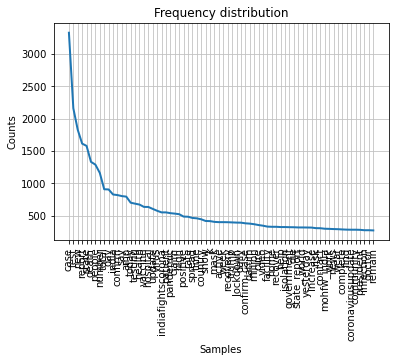

<AxesSubplot:title={'center':'Frequency distribution'}, xlabel='Samples', ylabel='Counts'>

In [12]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(word_count)
fdist_filtered.plot(70,title='Frequency distribution')

In [69]:
corpus_train_fake = data_train[data_train.label == "fake"]["tweet"]
corpus_train_real = data_train[data_train.label == "real"]["tweet"]
word_count_fake, output_fake, flat_fake, tokenized_texts_fake = pre_processer_fake(corpus_train_fake)
print(output_fake[:20])
word_count_real, output_real, flat_real, tokenized_texts_real = pre_processer_real(corpus_train_real)
print(output_real[:20])

[('say', 575), ('claim', 521), ('people', 507), ('virus', 441), ('vaccine', 405), ('trump', 390), ('pandemic', 368), ('case', 368), ('new', 366), ('test', 351), ('video', 327), ('india', 327), ('hospital', 319), ('death', 289), ('president', 277), ('show', 276), ('die', 271), ('cure', 266), ('lockdown', 250), ('patient', 238)]
[('case', 2963), ('test', 1811), ('report', 1481), ('new', 1463), ('state', 1371), ('number', 1057), ('death', 1044), ('total', 878), ('people', 783), ('confirm', 731), ('amp', 705), ('day', 693), ('today', 641), ('testing', 605), ('update', 577), ('indiafightscorona', 546), ('india', 501), ('health', 477), ('high', 459), ('k', 403)]


In [ ]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(word_count_fake)
fdist_filtered.plot(70,title='Frequency distribution fake news')

In [ ]:
fdist_filtered = FreqDist(word_count_real)
fdist_filtered.plot(70,title='Frequency distribution fake news')

# Results: Optimal number of topics

In [17]:
all_scores = []
for n in range(5, 20, 5):
    model_list, coherence_values = compute_coherence_values(texts=tokenized_texts, start=1, step=1, limit= 30, topn=n)
    all_scores.append(coherence_values)

In [18]:
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)

In [19]:
print(avg_scores)

[0.39772394 0.54183978 0.56157285 0.61638396 0.63184055 0.62105559
 0.63980566 0.65262145 0.6464288  0.66294754 0.66071794 0.64592668
 0.66620644 0.6400298  0.65946376 0.66851952 0.62794231 0.67390525
 0.66282757 0.67081121 0.64315102 0.67466953 0.65065064 0.66000087
 0.67658308 0.67357429 0.66235098 0.6569453  0.66025029 0.67326455
 0.65173371 0.67752198 0.66269691 0.65992461 0.66654484 0.68264526
 0.66002613 0.68653958 0.68039183]


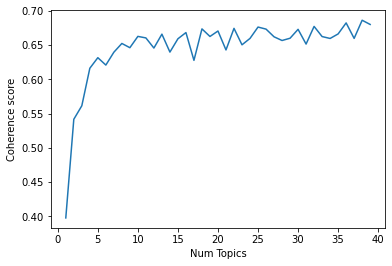

In [20]:
import matplotlib.pyplot as plt
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, avg_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
#plt.legend(("coherence_values"), loc='best')
#plt.title("")
plt.show()

In [56]:
all_scores = []
for n in range(5, 15, 5):
    model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_real, start=1, step=1, limit=40, topn=n)
    all_scores.append(coherence_values)

In [57]:
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)

In [58]:
print(avg_scores)

[0.40487525 0.48984591 0.57322864 0.65946385 0.63909269 0.57550685
 0.59952443 0.66196562 0.60224919 0.62672314 0.64901371 0.65067357
 0.64373607 0.65351643 0.66680515 0.65807585 0.66409237 0.65718164
 0.66739235 0.66868496 0.66384823 0.65472679 0.67261532 0.66198206
 0.68228554 0.65801206 0.68599336 0.66947956 0.68224529 0.67677458
 0.6768964  0.6781123  0.66704632 0.65783009 0.69114472 0.68759685
 0.67886558 0.66470013 0.67324454]


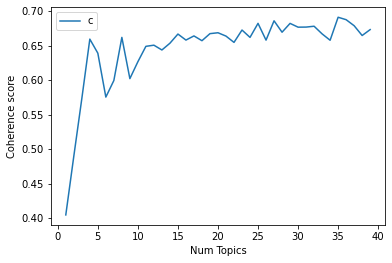

In [59]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, avg_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Results: Topic modelling LDA Gensim

#### Fake news

In [13]:
topics, lda_fake, dictionary = topic_modelling_results(tokenized_texts, 20, n_iterations = 1000)
topics

Topic  \
0      0   
1      1   
2      2   
3      3   
4      4   
5      5   
6      6   
7      7   
8      8   
9      9   
10    10   
11    11   
12    12   
13    13   
14    14   
15    15   
16    16   
17    17   
18    18   
19    19   

                                                                                                       Words  
0                                                lockdown rate year high plan school order local place start  
1                             test people positive testing include test_positive result negative link travel  
2                                        late minister read uk cdc restriction live government news increase  
3                                      vaccine country u.s new_york york trial announce develop end clinical  
4                                                  spread mask wear learn face public stay protect home hand  
5                                       risk symptom infection study long person medical reduce suggest life  
6                               health country outbreak child pandemic worker care population national month  
7                               day people facility isolation contact hospital manage quarantine close today  
8                                  number total test report complete level remain world total_number zealand  
9                         india indiafightscorona recovery mohfw_india lakh staysafe hour rate high covid_19  
10                               case confirm total active confirm_case active_case recover state cure today  
11                                       state pm follow time government pradesh maharashtra find april real  
12                                     report state test update daily state_report million track day publish  
13                                        amp testing work capacity increase support lab response lead issue  
14                                   state report datum hospitalization today week record rise south florida  
15                                            patient die hospital doctor show man video italy police infect  
16                                    pandemic trump president donald check news fact donaldtrump false call  
17                                         virus cure kill flu find water stop house drug hydroxychloroquine  
18                                          claim time post video share show china facebook chinese thousand  
19  death case confirm nigeria covid19nigeria discharge case_covid19nigeria discharged discharge_death great

#### All news

In [13]:
topics, lda_model, dictionary = topic_modelling_results(tokenized_texts, 20, n_iterations = 1000)
topics

Topic  \
0      0   
1      1   
2      2   
3      3   
4      4   
5      5   
6      6   
7      7   
8      8   
9      9   
10    10   
11    11   
12    12   
13    13   
14    14   
15    15   
16    16   
17    17   
18    18   
19    19   

                                                                                               Words  
0                                       spread mask wear face protect prevent hand stay learn social  
1   case death confirm discharge nigeria april pm covid19nigeria case_covid19nigeria discharge_death  
2                                         virus cure kill infect water food drink recommend stop air  
3    state testing covid_19 lab pradesh covid__19 coronavirusupdate amp maharashtra coronavirusindia  
4                            news world government good outbreak year fight end false alexismadrigal  
5             day facility isolation contact symptom manage quarantine close manage_isolation return  
6              case number total confirm report active confirm_case total_number new_zealand zealand  
7                           people hospital include patient person community auckland city care york  
8                                         risk people find child patient high flu group learn reduce  
9                                  amp health home worker public work early infection treatment life  
10                            pandemic trump president die donald bill china donaldtrump house gates  
11               india rate lockdown mohfw_india states country recovery low issue indiafightscorona  
12                         week datum increase hospitalization continue cdc rise south current level  
13                                          claim video show doctor post time share facebook die man  
14                             country minister uk government long live restriction late lockdown pm  
15                               vaccine dr trial disease chinese develop china wuhan clinical study  
16                    test positive testing number total complete yesterday test_positive bring date  
17                  india indiafightscorona day high recovery record lakh staysafe hour indiawillwin  
18                          state report death update daily today state_report track publish million  
19                           work plan support school read response provide pandemic measure service

#### Real news

In [86]:
topics_real, lda_real, dictionary = topic_modelling_results(tokenized_texts_real, 27, n_iterations = 1000)
topics_real

Topic  \
0      0   
1      1   
2      2   
3      3   
4      4   
5      5   
6      6   
7      7   
8      8   
9      9   
10    10   
11    11   
12    12   
13    13   
14    14   
15    15   
16    16   
17    17   
18    18   
19    19   
20    20   
21    21   
22    22   
23    23   
24    24   
25    25   
26    26   

                                                                                                                       Words  
0                                                 day contact close isolate source trace identify close_contact august start  
1                                                 case total active recover active_case death discharge cure confirm migrate  
2                                             people hospital include auckland level community cluster link remain household  
3                                                    testing lab capacity early amp treatment lead centre effective strategy  
4                                                               spread face mask learn wear protect slow stay prevent public  
5                                                               increase cdc show continue late report south visit u.s learn  
6                                          datum important good alexismadrigal change trial county data information question  
7                                                      uk restriction government late lockdown live read minister pm england  
8                                     rate recovery india high indiafightscorona mohfw_india low recovery_rate improve march  
9                                        number total complete test total_number bring date yesterday bring_total laboratory  
10                                       case confirm state confirm_case nigeria pm total total_confirm april report_nigeria  
11                           test positive testing people result negative test_positive antibody positive_rate negative_test  
12  covid_19 covid__19 today coronavirusupdate coronavirusindia mohfw_india covidupdate coronaupdate july covid__19_covid_19  
13                                                               death week report average low 7-day york new_york fall long  
14                                        amp home person distancing social takeresponsibility measure place avoid stay_home  
15                                                       health pandemic people child group population year follow world age  
16                                                         risk state high patient pradesh uts maharashtra states severe amp  
17                                                      report case today number record update probable high late_update set  
18                                          state number hospitalization report datum large california today florida current  
19                                                      amp health work support plan worker response school staff healthcare  
20                    indiafightscorona india staysafe indiawillwin lakh sample icmrdelhi hour conduct staysafe_indiawillwin  
21                                            test state report daily update state_report track million publish daily_update  
22                                                   symptom patient virus study continue transmission find read suggest key  
23                                                           country vaccine amp drtedros drtedro end ensure access life act  
24                                                time infection disease care outbreak travel month public emergency control  
25                           isolation facility manage manage_isolation community quarantine update zealand new_zealand case  
26                             death covid19nigeria discharge confirm case case_covid19nigeria discharge_death akwa april pm

In [ ]:
import gensim

import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda)

pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

## Document topic distribution

###### Loop over documents to get topic distribution: all

In [14]:
transformed_docs = lda_model.load_document_topics()

In [15]:
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

Topic distributions for document 0
(0, 0.03676470588235294)
(1, 0.051470588235294115)
(2, 0.03676470588235294)
(3, 0.03676470588235294)
(4, 0.0661764705882353)
(5, 0.051470588235294115)
(6, 0.051470588235294115)
(7, 0.0661764705882353)
(8, 0.051470588235294115)
(9, 0.03676470588235294)
(10, 0.03676470588235294)
(11, 0.03676470588235294)
(12, 0.051470588235294115)
(13, 0.03676470588235294)
(14, 0.03676470588235294)
(15, 0.03676470588235294)
(16, 0.03676470588235294)
(17, 0.051470588235294115)
(18, 0.13970588235294118)
(19, 0.051470588235294115)
Topic distributions for document 1
(0, 0.040322580645161296)
(1, 0.05645161290322582)
(2, 0.040322580645161296)
(3, 0.040322580645161296)
(4, 0.05645161290322582)
(5, 0.040322580645161296)
(6, 0.040322580645161296)
(7, 0.040322580645161296)
(8, 0.040322580645161296)
(9, 0.040322580645161296)
(10, 0.040322580645161296)
(11, 0.040322580645161296)
(12, 0.040322580645161296)
(13, 0.040322580645161296)
(14, 0.040322580645161296)
(15, 0.040322580645161

(12, 0.04807692307692306)
(13, 0.04807692307692306)
(14, 0.04807692307692306)
(15, 0.04807692307692306)
(16, 0.06730769230769228)
(17, 0.04807692307692306)
(18, 0.04807692307692306)
(19, 0.04807692307692306)
Topic distributions for document 91
(0, 0.03424657534246575)
(1, 0.03424657534246575)
(2, 0.03424657534246575)
(3, 0.06164383561643835)
(4, 0.03424657534246575)
(5, 0.04794520547945205)
(6, 0.03424657534246575)
(7, 0.04794520547945205)
(8, 0.03424657534246575)
(9, 0.04794520547945205)
(10, 0.03424657534246575)
(11, 0.07534246575342465)
(12, 0.03424657534246575)
(13, 0.03424657534246575)
(14, 0.06164383561643835)
(15, 0.03424657534246575)
(16, 0.08904109589041095)
(17, 0.11643835616438356)
(18, 0.04794520547945205)
(19, 0.06164383561643835)
Topic distributions for document 92
(0, 0.04385964912280701)
(1, 0.04385964912280701)
(2, 0.04385964912280701)
(3, 0.04385964912280701)
(4, 0.06140350877192981)
(5, 0.04385964912280701)
(6, 0.04385964912280701)
(7, 0.04385964912280701)
(8, 0.0438

Topic distributions for document 162
(0, 0.03968253968253969)
(1, 0.055555555555555566)
(2, 0.03968253968253969)
(3, 0.055555555555555566)
(4, 0.03968253968253969)
(5, 0.03968253968253969)
(6, 0.055555555555555566)
(7, 0.055555555555555566)
(8, 0.03968253968253969)
(9, 0.03968253968253969)
(10, 0.03968253968253969)
(11, 0.055555555555555566)
(12, 0.1507936507936508)
(13, 0.03968253968253969)
(14, 0.03968253968253969)
(15, 0.03968253968253969)
(16, 0.055555555555555566)
(17, 0.03968253968253969)
(18, 0.03968253968253969)
(19, 0.03968253968253969)
Topic distributions for document 163
(0, 0.036231884057971)
(1, 0.036231884057971)
(2, 0.036231884057971)
(3, 0.07971014492753618)
(4, 0.0942028985507246)
(5, 0.0652173913043478)
(6, 0.036231884057971)
(7, 0.036231884057971)
(8, 0.0652173913043478)
(9, 0.036231884057971)
(10, 0.0507246376811594)
(11, 0.036231884057971)
(12, 0.036231884057971)
(13, 0.036231884057971)
(14, 0.0652173913043478)
(15, 0.108695652173913)
(16, 0.036231884057971)
(17, 0

(4, 0.031645569620253174)
(5, 0.031645569620253174)
(6, 0.15822784810126586)
(7, 0.031645569620253174)
(8, 0.031645569620253174)
(9, 0.031645569620253174)
(10, 0.031645569620253174)
(11, 0.04430379746835444)
(12, 0.031645569620253174)
(13, 0.031645569620253174)
(14, 0.031645569620253174)
(15, 0.031645569620253174)
(16, 0.19620253164556967)
(17, 0.031645569620253174)
(18, 0.04430379746835444)
(19, 0.031645569620253174)
Topic distributions for document 258
(0, 0.03246753246753247)
(1, 0.03246753246753247)
(2, 0.03246753246753247)
(3, 0.03246753246753247)
(4, 0.07142857142857144)
(5, 0.03246753246753247)
(6, 0.03246753246753247)
(7, 0.03246753246753247)
(8, 0.03246753246753247)
(9, 0.03246753246753247)
(10, 0.03246753246753247)
(11, 0.04545454545454546)
(12, 0.058441558441558454)
(13, 0.03246753246753247)
(14, 0.03246753246753247)
(15, 0.04545454545454546)
(16, 0.04545454545454546)
(17, 0.03246753246753247)
(18, 0.26623376623376627)
(19, 0.04545454545454546)
Topic distributions for docume

(12, 0.043103448275862065)
(13, 0.043103448275862065)
(14, 0.043103448275862065)
(15, 0.043103448275862065)
(16, 0.043103448275862065)
(17, 0.07758620689655171)
(18, 0.060344827586206885)
(19, 0.043103448275862065)
Topic distributions for document 329
(0, 0.03623188405797101)
(1, 0.03623188405797101)
(2, 0.03623188405797101)
(3, 0.03623188405797101)
(4, 0.06521739130434781)
(5, 0.05072463768115941)
(6, 0.06521739130434781)
(7, 0.03623188405797101)
(8, 0.06521739130434781)
(9, 0.03623188405797101)
(10, 0.03623188405797101)
(11, 0.03623188405797101)
(12, 0.13768115942028983)
(13, 0.05072463768115941)
(14, 0.03623188405797101)
(15, 0.07971014492753621)
(16, 0.05072463768115941)
(17, 0.03623188405797101)
(18, 0.03623188405797101)
(19, 0.03623188405797101)
Topic distributions for document 330
(0, 0.04237288135593221)
(1, 0.04237288135593221)
(2, 0.05932203389830509)
(3, 0.04237288135593221)
(4, 0.04237288135593221)
(5, 0.07627118644067798)
(6, 0.04237288135593221)
(7, 0.04237288135593221)
(

Topic distributions for document 407
(0, 0.039682539682539694)
(1, 0.039682539682539694)
(2, 0.05555555555555557)
(3, 0.039682539682539694)
(4, 0.039682539682539694)
(5, 0.039682539682539694)
(6, 0.11904761904761908)
(7, 0.039682539682539694)
(8, 0.039682539682539694)
(9, 0.039682539682539694)
(10, 0.039682539682539694)
(11, 0.039682539682539694)
(12, 0.039682539682539694)
(13, 0.039682539682539694)
(14, 0.039682539682539694)
(15, 0.039682539682539694)
(16, 0.15079365079365084)
(17, 0.039682539682539694)
(18, 0.039682539682539694)
(19, 0.039682539682539694)
Topic distributions for document 408
(0, 0.04464285714285715)
(1, 0.04464285714285715)
(2, 0.06250000000000001)
(3, 0.04464285714285715)
(4, 0.04464285714285715)
(5, 0.04464285714285715)
(6, 0.04464285714285715)
(7, 0.06250000000000001)
(8, 0.04464285714285715)
(9, 0.04464285714285715)
(10, 0.08035714285714288)
(11, 0.04464285714285715)
(12, 0.04464285714285715)
(13, 0.08035714285714288)
(14, 0.04464285714285715)
(15, 0.044642857142

(4, 0.04464285714285716)
(5, 0.04464285714285716)
(6, 0.04464285714285716)
(7, 0.06250000000000003)
(8, 0.06250000000000003)
(9, 0.04464285714285716)
(10, 0.04464285714285716)
(11, 0.04464285714285716)
(12, 0.06250000000000003)
(13, 0.04464285714285716)
(14, 0.04464285714285716)
(15, 0.04464285714285716)
(16, 0.06250000000000003)
(17, 0.04464285714285716)
(18, 0.04464285714285716)
(19, 0.04464285714285716)
Topic distributions for document 496
(0, 0.0403225806451613)
(1, 0.0403225806451613)
(2, 0.056451612903225826)
(3, 0.0403225806451613)
(4, 0.0403225806451613)
(5, 0.07258064516129036)
(6, 0.0403225806451613)
(7, 0.056451612903225826)
(8, 0.0403225806451613)
(9, 0.08870967741935487)
(10, 0.0403225806451613)
(11, 0.07258064516129036)
(12, 0.056451612903225826)
(13, 0.0403225806451613)
(14, 0.0403225806451613)
(15, 0.0403225806451613)
(16, 0.0403225806451613)
(17, 0.056451612903225826)
(18, 0.056451612903225826)
(19, 0.0403225806451613)
Topic distributions for document 497
(0, 0.0320512

(13, 0.051470588235294115)
(14, 0.09558823529411764)
(15, 0.03676470588235294)
(16, 0.0661764705882353)
(17, 0.03676470588235294)
(18, 0.03676470588235294)
(19, 0.08088235294117647)
Topic distributions for document 567
(0, 0.03086419753086419)
(1, 0.04320987654320987)
(2, 0.03086419753086419)
(3, 0.05555555555555554)
(4, 0.03086419753086419)
(5, 0.04320987654320987)
(6, 0.0802469135802469)
(7, 0.05555555555555554)
(8, 0.05555555555555554)
(9, 0.04320987654320987)
(10, 0.03086419753086419)
(11, 0.03086419753086419)
(12, 0.0802469135802469)
(13, 0.03086419753086419)
(14, 0.03086419753086419)
(15, 0.03086419753086419)
(16, 0.0802469135802469)
(17, 0.04320987654320987)
(18, 0.05555555555555554)
(19, 0.11728395061728392)
Topic distributions for document 568
(0, 0.0373134328358209)
(1, 0.0373134328358209)
(2, 0.0373134328358209)
(3, 0.0373134328358209)
(4, 0.0373134328358209)
(5, 0.18656716417910452)
(6, 0.14179104477611942)
(7, 0.0373134328358209)
(8, 0.0373134328358209)
(9, 0.0373134328358

(0, 0.05833333333333335)
(1, 0.04166666666666667)
(2, 0.1416666666666667)
(3, 0.04166666666666667)
(4, 0.04166666666666667)
(5, 0.04166666666666667)
(6, 0.04166666666666667)
(7, 0.04166666666666667)
(8, 0.05833333333333335)
(9, 0.05833333333333335)
(10, 0.04166666666666667)
(11, 0.04166666666666667)
(12, 0.04166666666666667)
(13, 0.04166666666666667)
(14, 0.04166666666666667)
(15, 0.04166666666666667)
(16, 0.05833333333333335)
(17, 0.04166666666666667)
(18, 0.04166666666666667)
(19, 0.04166666666666667)
Topic distributions for document 639
(0, 0.03125000000000001)
(1, 0.3062500000000001)
(2, 0.043750000000000004)
(3, 0.03125000000000001)
(4, 0.043750000000000004)
(5, 0.03125000000000001)
(6, 0.03125000000000001)
(7, 0.03125000000000001)
(8, 0.03125000000000001)
(9, 0.03125000000000001)
(10, 0.03125000000000001)
(11, 0.03125000000000001)
(12, 0.03125000000000001)
(13, 0.043750000000000004)
(14, 0.043750000000000004)
(15, 0.03125000000000001)
(16, 0.05625000000000001)
(17, 0.043750000000

(5, 0.03676470588235294)
(6, 0.03676470588235294)
(7, 0.0661764705882353)
(8, 0.051470588235294115)
(9, 0.0661764705882353)
(10, 0.11029411764705882)
(11, 0.03676470588235294)
(12, 0.03676470588235294)
(13, 0.11029411764705882)
(14, 0.03676470588235294)
(15, 0.051470588235294115)
(16, 0.03676470588235294)
(17, 0.03676470588235294)
(18, 0.051470588235294115)
(19, 0.03676470588235294)
Topic distributions for document 734
(0, 0.060344827586206885)
(1, 0.043103448275862065)
(2, 0.043103448275862065)
(3, 0.060344827586206885)
(4, 0.043103448275862065)
(5, 0.043103448275862065)
(6, 0.043103448275862065)
(7, 0.043103448275862065)
(8, 0.043103448275862065)
(9, 0.043103448275862065)
(10, 0.11206896551724135)
(11, 0.043103448275862065)
(12, 0.043103448275862065)
(13, 0.043103448275862065)
(14, 0.060344827586206885)
(15, 0.043103448275862065)
(16, 0.043103448275862065)
(17, 0.043103448275862065)
(18, 0.060344827586206885)
(19, 0.043103448275862065)
Topic distributions for document 735
(0, 0.03378

(9, 0.06923076923076925)
(10, 0.053846153846153856)
(11, 0.03846153846153847)
(12, 0.053846153846153856)
(13, 0.10000000000000002)
(14, 0.06923076923076925)
(15, 0.053846153846153856)
(16, 0.03846153846153847)
(17, 0.03846153846153847)
(18, 0.03846153846153847)
(19, 0.053846153846153856)
Topic distributions for document 829
(0, 0.04716981132075473)
(1, 0.04716981132075473)
(2, 0.04716981132075473)
(3, 0.04716981132075473)
(4, 0.06603773584905662)
(5, 0.04716981132075473)
(6, 0.04716981132075473)
(7, 0.04716981132075473)
(8, 0.04716981132075473)
(9, 0.04716981132075473)
(10, 0.06603773584905662)
(11, 0.04716981132075473)
(12, 0.04716981132075473)
(13, 0.04716981132075473)
(14, 0.04716981132075473)
(15, 0.04716981132075473)
(16, 0.06603773584905662)
(17, 0.04716981132075473)
(18, 0.04716981132075473)
(19, 0.04716981132075473)
Topic distributions for document 830
(0, 0.03333333333333333)
(1, 0.03333333333333333)
(2, 0.03333333333333333)
(3, 0.03333333333333333)
(4, 0.03333333333333333)
(5

(16, 0.03289473684210526)
(17, 0.03289473684210526)
(18, 0.046052631578947366)
(19, 0.05921052631578947)
Topic distributions for document 907
(0, 0.1015625)
(1, 0.0390625)
(2, 0.0546875)
(3, 0.0390625)
(4, 0.0390625)
(5, 0.0546875)
(6, 0.0390625)
(7, 0.0703125)
(8, 0.0859375)
(9, 0.0390625)
(10, 0.0390625)
(11, 0.0390625)
(12, 0.0390625)
(13, 0.0390625)
(14, 0.0546875)
(15, 0.0390625)
(16, 0.0390625)
(17, 0.0390625)
(18, 0.0390625)
(19, 0.0703125)
Topic distributions for document 908
(0, 0.056451612903225826)
(1, 0.056451612903225826)
(2, 0.0403225806451613)
(3, 0.0403225806451613)
(4, 0.0403225806451613)
(5, 0.0403225806451613)
(6, 0.0403225806451613)
(7, 0.1048387096774194)
(8, 0.0403225806451613)
(9, 0.0403225806451613)
(10, 0.056451612903225826)
(11, 0.056451612903225826)
(12, 0.07258064516129036)
(13, 0.0403225806451613)
(14, 0.0403225806451613)
(15, 0.0403225806451613)
(16, 0.0403225806451613)
(17, 0.056451612903225826)
(18, 0.056451612903225826)
(19, 0.0403225806451613)
Topic di

(14, 0.056451612903225826)
(15, 0.0403225806451613)
(16, 0.056451612903225826)
(17, 0.07258064516129036)
(18, 0.0403225806451613)
(19, 0.056451612903225826)
Topic distributions for document 984
(0, 0.1416666666666667)
(1, 0.04166666666666667)
(2, 0.04166666666666667)
(3, 0.04166666666666667)
(4, 0.04166666666666667)
(5, 0.04166666666666667)
(6, 0.04166666666666667)
(7, 0.04166666666666667)
(8, 0.04166666666666667)
(9, 0.04166666666666667)
(10, 0.04166666666666667)
(11, 0.04166666666666667)
(12, 0.05833333333333335)
(13, 0.04166666666666667)
(14, 0.04166666666666667)
(15, 0.09166666666666667)
(16, 0.04166666666666667)
(17, 0.04166666666666667)
(18, 0.04166666666666667)
(19, 0.04166666666666667)
Topic distributions for document 985
(0, 0.035211267605633804)
(1, 0.035211267605633804)
(2, 0.035211267605633804)
(3, 0.035211267605633804)
(4, 0.035211267605633804)
(5, 0.035211267605633804)
(6, 0.04929577464788732)
(7, 0.035211267605633804)
(8, 0.035211267605633804)
(9, 0.035211267605633804)
(

(10, 0.03378378378378379)
(11, 0.03378378378378379)
(12, 0.03378378378378379)
(13, 0.03378378378378379)
(14, 0.03378378378378379)
(15, 0.03378378378378379)
(16, 0.07432432432432434)
(17, 0.03378378378378379)
(18, 0.3175675675675676)
(19, 0.03378378378378379)
Topic distributions for document 1067
(0, 0.03424657534246576)
(1, 0.04794520547945206)
(2, 0.03424657534246576)
(3, 0.04794520547945206)
(4, 0.03424657534246576)
(5, 0.03424657534246576)
(6, 0.03424657534246576)
(7, 0.08904109589041097)
(8, 0.03424657534246576)
(9, 0.07534246575342467)
(10, 0.04794520547945206)
(11, 0.07534246575342467)
(12, 0.13013698630136988)
(13, 0.03424657534246576)
(14, 0.04794520547945206)
(15, 0.03424657534246576)
(16, 0.03424657534246576)
(17, 0.03424657534246576)
(18, 0.04794520547945206)
(19, 0.04794520547945206)
Topic distributions for document 1068
(0, 0.03333333333333334)
(1, 0.03333333333333334)
(2, 0.046666666666666676)
(3, 0.03333333333333334)
(4, 0.03333333333333334)
(5, 0.03333333333333334)
(6, 

(15, 0.03246753246753248)
(16, 0.03246753246753248)
(17, 0.03246753246753248)
(18, 0.03246753246753248)
(19, 0.09740259740259745)
Topic distributions for document 1159
(0, 0.03676470588235295)
(1, 0.03676470588235295)
(2, 0.03676470588235295)
(3, 0.08088235294117649)
(4, 0.05147058823529412)
(5, 0.03676470588235295)
(6, 0.05147058823529412)
(7, 0.05147058823529412)
(8, 0.06617647058823531)
(9, 0.03676470588235295)
(10, 0.03676470588235295)
(11, 0.03676470588235295)
(12, 0.12500000000000003)
(13, 0.03676470588235295)
(14, 0.03676470588235295)
(15, 0.03676470588235295)
(16, 0.03676470588235295)
(17, 0.05147058823529412)
(18, 0.06617647058823531)
(19, 0.05147058823529412)
Topic distributions for document 1160
(0, 0.03521126760563381)
(1, 0.03521126760563381)
(2, 0.03521126760563381)
(3, 0.049295774647887335)
(4, 0.03521126760563381)
(5, 0.049295774647887335)
(6, 0.03521126760563381)
(7, 0.03521126760563381)
(8, 0.03521126760563381)
(9, 0.03521126760563381)
(10, 0.03521126760563381)
(11, 0

(2, 0.0546875)
(3, 0.1015625)
(4, 0.0703125)
(5, 0.0390625)
(6, 0.0390625)
(7, 0.0390625)
(8, 0.0390625)
(9, 0.0390625)
(10, 0.0390625)
(11, 0.0390625)
(12, 0.0546875)
(13, 0.0703125)
(14, 0.0546875)
(15, 0.0390625)
(16, 0.0390625)
(17, 0.0390625)
(18, 0.0546875)
(19, 0.0703125)
Topic distributions for document 1234
(0, 0.039682539682539694)
(1, 0.039682539682539694)
(2, 0.039682539682539694)
(3, 0.039682539682539694)
(4, 0.039682539682539694)
(5, 0.21428571428571436)
(6, 0.039682539682539694)
(7, 0.039682539682539694)
(8, 0.039682539682539694)
(9, 0.039682539682539694)
(10, 0.039682539682539694)
(11, 0.039682539682539694)
(12, 0.039682539682539694)
(13, 0.039682539682539694)
(14, 0.039682539682539694)
(15, 0.039682539682539694)
(16, 0.039682539682539694)
(17, 0.05555555555555557)
(18, 0.039682539682539694)
(19, 0.05555555555555557)
Topic distributions for document 1235
(0, 0.10833333333333338)
(1, 0.058333333333333355)
(2, 0.04166666666666668)
(3, 0.04166666666666668)
(4, 0.0583333333

(6, 0.05223880597014926)
(7, 0.0373134328358209)
(8, 0.0373134328358209)
(9, 0.05223880597014926)
(10, 0.0373134328358209)
(11, 0.0373134328358209)
(12, 0.0373134328358209)
(13, 0.05223880597014926)
(14, 0.1567164179104478)
(15, 0.0373134328358209)
(16, 0.0373134328358209)
(17, 0.0373134328358209)
(18, 0.0373134328358209)
(19, 0.1119402985074627)
Topic distributions for document 1329
(0, 0.03676470588235295)
(1, 0.03676470588235295)
(2, 0.03676470588235295)
(3, 0.2573529411764706)
(4, 0.03676470588235295)
(5, 0.03676470588235295)
(6, 0.03676470588235295)
(7, 0.03676470588235295)
(8, 0.03676470588235295)
(9, 0.03676470588235295)
(10, 0.03676470588235295)
(11, 0.03676470588235295)
(12, 0.03676470588235295)
(13, 0.03676470588235295)
(14, 0.05147058823529412)
(15, 0.03676470588235295)
(16, 0.05147058823529412)
(17, 0.03676470588235295)
(18, 0.05147058823529412)
(19, 0.03676470588235295)
Topic distributions for document 1330
(0, 0.053846153846153856)
(1, 0.03846153846153847)
(2, 0.038461538

(15, 0.05833333333333334)
(16, 0.04166666666666667)
(17, 0.04166666666666667)
(18, 0.04166666666666667)
(19, 0.04166666666666667)
Topic distributions for document 1400
(0, 0.03731343283582089)
(1, 0.05223880597014925)
(2, 0.03731343283582089)
(3, 0.03731343283582089)
(4, 0.03731343283582089)
(5, 0.05223880597014925)
(6, 0.06716417910447761)
(7, 0.03731343283582089)
(8, 0.03731343283582089)
(9, 0.03731343283582089)
(10, 0.03731343283582089)
(11, 0.05223880597014925)
(12, 0.05223880597014925)
(13, 0.05223880597014925)
(14, 0.03731343283582089)
(15, 0.03731343283582089)
(16, 0.03731343283582089)
(17, 0.12686567164179105)
(18, 0.09701492537313433)
(19, 0.03731343283582089)
Topic distributions for document 1401
(0, 0.05147058823529412)
(1, 0.03676470588235295)
(2, 0.03676470588235295)
(3, 0.03676470588235295)
(4, 0.05147058823529412)
(5, 0.06617647058823531)
(6, 0.03676470588235295)
(7, 0.05147058823529412)
(8, 0.03676470588235295)
(9, 0.11029411764705883)
(10, 0.03676470588235295)
(11, 0.0

(4, 0.0396825396825397)
(5, 0.0396825396825397)
(6, 0.08730158730158734)
(7, 0.0396825396825397)
(8, 0.0396825396825397)
(9, 0.0396825396825397)
(10, 0.0396825396825397)
(11, 0.0396825396825397)
(12, 0.0396825396825397)
(13, 0.19841269841269848)
(14, 0.0396825396825397)
(15, 0.0396825396825397)
(16, 0.0396825396825397)
(17, 0.0396825396825397)
(18, 0.0396825396825397)
(19, 0.0396825396825397)
Topic distributions for document 1483
(0, 0.04098360655737704)
(1, 0.057377049180327856)
(2, 0.04098360655737704)
(3, 0.04098360655737704)
(4, 0.04098360655737704)
(5, 0.0901639344262295)
(6, 0.04098360655737704)
(7, 0.04098360655737704)
(8, 0.04098360655737704)
(9, 0.07377049180327867)
(10, 0.07377049180327867)
(11, 0.04098360655737704)
(12, 0.04098360655737704)
(13, 0.04098360655737704)
(14, 0.04098360655737704)
(15, 0.04098360655737704)
(16, 0.04098360655737704)
(17, 0.0901639344262295)
(18, 0.04098360655737704)
(19, 0.04098360655737704)
Topic distributions for document 1484
(0, 0.0431034482758

Topic distributions for document 1557
(0, 0.03378378378378379)
(1, 0.04729729729729731)
(2, 0.03378378378378379)
(3, 0.03378378378378379)
(4, 0.03378378378378379)
(5, 0.03378378378378379)
(6, 0.04729729729729731)
(7, 0.11486486486486489)
(8, 0.03378378378378379)
(9, 0.03378378378378379)
(10, 0.03378378378378379)
(11, 0.03378378378378379)
(12, 0.07432432432432434)
(13, 0.03378378378378379)
(14, 0.03378378378378379)
(15, 0.04729729729729731)
(16, 0.03378378378378379)
(17, 0.04729729729729731)
(18, 0.18243243243243246)
(19, 0.03378378378378379)
Topic distributions for document 1558
(0, 0.03676470588235294)
(1, 0.03676470588235294)
(2, 0.03676470588235294)
(3, 0.03676470588235294)
(4, 0.03676470588235294)
(5, 0.03676470588235294)
(6, 0.03676470588235294)
(7, 0.03676470588235294)
(8, 0.03676470588235294)
(9, 0.22794117647058823)
(10, 0.03676470588235294)
(11, 0.03676470588235294)
(12, 0.051470588235294115)
(13, 0.03676470588235294)
(14, 0.03676470588235294)
(15, 0.051470588235294115)
(16, 0

(15, 0.03968253968253969)
(16, 0.03968253968253969)
(17, 0.03968253968253969)
(18, 0.03968253968253969)
(19, 0.03968253968253969)
Topic distributions for document 1638
(0, 0.040322580645161296)
(1, 0.040322580645161296)
(2, 0.07258064516129034)
(3, 0.040322580645161296)
(4, 0.05645161290322582)
(5, 0.05645161290322582)
(6, 0.05645161290322582)
(7, 0.040322580645161296)
(8, 0.040322580645161296)
(9, 0.05645161290322582)
(10, 0.040322580645161296)
(11, 0.040322580645161296)
(12, 0.040322580645161296)
(13, 0.040322580645161296)
(14, 0.040322580645161296)
(15, 0.07258064516129034)
(16, 0.040322580645161296)
(17, 0.040322580645161296)
(18, 0.040322580645161296)
(19, 0.10483870967741939)
Topic distributions for document 1639
(0, 0.08208955223880597)
(1, 0.03731343283582089)
(2, 0.06716417910447761)
(3, 0.03731343283582089)
(4, 0.03731343283582089)
(5, 0.03731343283582089)
(6, 0.05223880597014925)
(7, 0.03731343283582089)
(8, 0.05223880597014925)
(9, 0.12686567164179105)
(10, 0.05223880597014

Topic distributions for document 1733
(0, 0.0390625)
(1, 0.0390625)
(2, 0.0859375)
(3, 0.0546875)
(4, 0.0703125)
(5, 0.0390625)
(6, 0.0546875)
(7, 0.0390625)
(8, 0.0390625)
(9, 0.0390625)
(10, 0.0703125)
(11, 0.0390625)
(12, 0.0390625)
(13, 0.0703125)
(14, 0.0859375)
(15, 0.0390625)
(16, 0.0390625)
(17, 0.0390625)
(18, 0.0390625)
(19, 0.0390625)
Topic distributions for document 1734
(0, 0.043859649122807015)
(1, 0.043859649122807015)
(2, 0.043859649122807015)
(3, 0.06140350877192982)
(4, 0.043859649122807015)
(5, 0.043859649122807015)
(6, 0.043859649122807015)
(7, 0.043859649122807015)
(8, 0.043859649122807015)
(9, 0.06140350877192982)
(10, 0.06140350877192982)
(11, 0.043859649122807015)
(12, 0.06140350877192982)
(13, 0.043859649122807015)
(14, 0.043859649122807015)
(15, 0.06140350877192982)
(16, 0.043859649122807015)
(17, 0.043859649122807015)
(18, 0.07894736842105263)
(19, 0.043859649122807015)
Topic distributions for document 1735
(0, 0.04487179487179488)
(1, 0.0576923076923077)
(2,

(3, 0.04545454545454546)
(4, 0.04545454545454546)
(5, 0.04545454545454546)
(6, 0.04545454545454546)
(7, 0.04545454545454546)
(8, 0.04545454545454546)
(9, 0.04545454545454546)
(10, 0.06363636363636364)
(11, 0.04545454545454546)
(12, 0.06363636363636364)
(13, 0.06363636363636364)
(14, 0.04545454545454546)
(15, 0.08181818181818183)
(16, 0.04545454545454546)
(17, 0.04545454545454546)
(18, 0.04545454545454546)
(19, 0.04545454545454546)
Topic distributions for document 1829
(0, 0.04166666666666668)
(1, 0.04166666666666668)
(2, 0.07500000000000002)
(3, 0.04166666666666668)
(4, 0.058333333333333355)
(5, 0.04166666666666668)
(6, 0.04166666666666668)
(7, 0.07500000000000002)
(8, 0.07500000000000002)
(9, 0.04166666666666668)
(10, 0.058333333333333355)
(11, 0.04166666666666668)
(12, 0.04166666666666668)
(13, 0.04166666666666668)
(14, 0.04166666666666668)
(15, 0.04166666666666668)
(16, 0.04166666666666668)
(17, 0.04166666666666668)
(18, 0.04166666666666668)
(19, 0.07500000000000002)
Topic distribut

(11, 0.038461538461538464)
(12, 0.08461538461538462)
(13, 0.038461538461538464)
(14, 0.06923076923076923)
(15, 0.038461538461538464)
(16, 0.05384615384615385)
(17, 0.038461538461538464)
(18, 0.05384615384615385)
(19, 0.05384615384615385)
Topic distributions for document 1915
(0, 0.07142857142857145)
(1, 0.04545454545454548)
(2, 0.03246753246753248)
(3, 0.03246753246753248)
(4, 0.05844155844155847)
(5, 0.07142857142857145)
(6, 0.03246753246753248)
(7, 0.05844155844155847)
(8, 0.09740259740259745)
(9, 0.03246753246753248)
(10, 0.03246753246753248)
(11, 0.03246753246753248)
(12, 0.04545454545454548)
(13, 0.04545454545454548)
(14, 0.04545454545454548)
(15, 0.03246753246753248)
(16, 0.03246753246753248)
(17, 0.05844155844155847)
(18, 0.03246753246753248)
(19, 0.11038961038961044)
Topic distributions for document 1916
(0, 0.09649122807017543)
(1, 0.043859649122807015)
(2, 0.043859649122807015)
(3, 0.043859649122807015)
(4, 0.043859649122807015)
(5, 0.043859649122807015)
(6, 0.043859649122807

(16, 0.04464285714285716)
(17, 0.04464285714285716)
(18, 0.04464285714285716)
(19, 0.04464285714285716)
Topic distributions for document 1995
(0, 0.03333333333333334)
(1, 0.046666666666666676)
(2, 0.03333333333333334)
(3, 0.03333333333333334)
(4, 0.03333333333333334)
(5, 0.03333333333333334)
(6, 0.046666666666666676)
(7, 0.060000000000000005)
(8, 0.03333333333333334)
(9, 0.03333333333333334)
(10, 0.046666666666666676)
(11, 0.03333333333333334)
(12, 0.046666666666666676)
(13, 0.060000000000000005)
(14, 0.03333333333333334)
(15, 0.03333333333333334)
(16, 0.03333333333333334)
(17, 0.046666666666666676)
(18, 0.2466666666666667)
(19, 0.03333333333333334)
Topic distributions for document 1996
(0, 0.04545454545454547)
(1, 0.04545454545454547)
(2, 0.04545454545454547)
(3, 0.04545454545454547)
(4, 0.06363636363636366)
(5, 0.04545454545454547)
(6, 0.04545454545454547)
(7, 0.04545454545454547)
(8, 0.06363636363636366)
(9, 0.04545454545454547)
(10, 0.04545454545454547)
(11, 0.04545454545454547)
(1

Topic distributions for document 2076
(0, 0.060344827586206885)
(1, 0.043103448275862065)
(2, 0.043103448275862065)
(3, 0.043103448275862065)
(4, 0.043103448275862065)
(5, 0.043103448275862065)
(6, 0.060344827586206885)
(7, 0.043103448275862065)
(8, 0.043103448275862065)
(9, 0.043103448275862065)
(10, 0.043103448275862065)
(11, 0.043103448275862065)
(12, 0.043103448275862065)
(13, 0.043103448275862065)
(14, 0.043103448275862065)
(15, 0.060344827586206885)
(16, 0.043103448275862065)
(17, 0.043103448275862065)
(18, 0.11206896551724135)
(19, 0.060344827586206885)
Topic distributions for document 2077
(0, 0.03289473684210526)
(1, 0.03289473684210526)
(2, 0.03289473684210526)
(3, 0.05921052631578947)
(4, 0.03289473684210526)
(5, 0.08552631578947369)
(6, 0.03289473684210526)
(7, 0.046052631578947366)
(8, 0.05921052631578947)
(9, 0.08552631578947369)
(10, 0.046052631578947366)
(11, 0.046052631578947366)
(12, 0.046052631578947366)
(13, 0.03289473684210526)
(14, 0.03289473684210526)
(15, 0.0328

(8, 0.03846153846153847)
(9, 0.03846153846153847)
(10, 0.06923076923076925)
(11, 0.03846153846153847)
(12, 0.1153846153846154)
(13, 0.03846153846153847)
(14, 0.06923076923076925)
(15, 0.03846153846153847)
(16, 0.053846153846153856)
(17, 0.03846153846153847)
(18, 0.053846153846153856)
(19, 0.03846153846153847)
Topic distributions for document 2162
(0, 0.03424657534246575)
(1, 0.03424657534246575)
(2, 0.03424657534246575)
(3, 0.03424657534246575)
(4, 0.03424657534246575)
(5, 0.03424657534246575)
(6, 0.04794520547945205)
(7, 0.04794520547945205)
(8, 0.04794520547945205)
(9, 0.23972602739726026)
(10, 0.04794520547945205)
(11, 0.03424657534246575)
(12, 0.03424657534246575)
(13, 0.03424657534246575)
(14, 0.07534246575342465)
(15, 0.03424657534246575)
(16, 0.03424657534246575)
(17, 0.04794520547945205)
(18, 0.03424657534246575)
(19, 0.03424657534246575)
Topic distributions for document 2163
(0, 0.04237288135593221)
(1, 0.04237288135593221)
(2, 0.07627118644067798)
(3, 0.04237288135593221)
(4,

(19, 0.0462962962962963)
Topic distributions for document 2250
(0, 0.057377049180327856)
(1, 0.04098360655737704)
(2, 0.04098360655737704)
(3, 0.04098360655737704)
(4, 0.04098360655737704)
(5, 0.0901639344262295)
(6, 0.04098360655737704)
(7, 0.04098360655737704)
(8, 0.04098360655737704)
(9, 0.057377049180327856)
(10, 0.057377049180327856)
(11, 0.04098360655737704)
(12, 0.04098360655737704)
(13, 0.04098360655737704)
(14, 0.04098360655737704)
(15, 0.0901639344262295)
(16, 0.04098360655737704)
(17, 0.04098360655737704)
(18, 0.04098360655737704)
(19, 0.07377049180327867)
Topic distributions for document 2251
(0, 0.043103448275862065)
(1, 0.043103448275862065)
(2, 0.043103448275862065)
(3, 0.043103448275862065)
(4, 0.060344827586206885)
(5, 0.09482758620689652)
(6, 0.07758620689655171)
(7, 0.043103448275862065)
(8, 0.043103448275862065)
(9, 0.043103448275862065)
(10, 0.043103448275862065)
(11, 0.043103448275862065)
(12, 0.043103448275862065)
(13, 0.043103448275862065)
(14, 0.043103448275862

(0, 0.04430379746835444)
(1, 0.031645569620253174)
(2, 0.0569620253164557)
(3, 0.031645569620253174)
(4, 0.14556962025316458)
(5, 0.031645569620253174)
(6, 0.04430379746835444)
(7, 0.031645569620253174)
(8, 0.031645569620253174)
(9, 0.0569620253164557)
(10, 0.0569620253164557)
(11, 0.031645569620253174)
(12, 0.04430379746835444)
(13, 0.04430379746835444)
(14, 0.04430379746835444)
(15, 0.031645569620253174)
(16, 0.031645569620253174)
(17, 0.031645569620253174)
(18, 0.031645569620253174)
(19, 0.14556962025316458)
Topic distributions for document 2329
(0, 0.04237288135593221)
(1, 0.04237288135593221)
(2, 0.05932203389830509)
(3, 0.05932203389830509)
(4, 0.12711864406779663)
(5, 0.04237288135593221)
(6, 0.04237288135593221)
(7, 0.04237288135593221)
(8, 0.04237288135593221)
(9, 0.04237288135593221)
(10, 0.04237288135593221)
(11, 0.05932203389830509)
(12, 0.04237288135593221)
(13, 0.04237288135593221)
(14, 0.04237288135593221)
(15, 0.05932203389830509)
(16, 0.04237288135593221)
(17, 0.042372

(5, 0.03571428571428572)
(6, 0.19285714285714292)
(7, 0.03571428571428572)
(8, 0.03571428571428572)
(9, 0.03571428571428572)
(10, 0.03571428571428572)
(11, 0.0642857142857143)
(12, 0.03571428571428572)
(13, 0.03571428571428572)
(14, 0.03571428571428572)
(15, 0.03571428571428572)
(16, 0.03571428571428572)
(17, 0.09285714285714287)
(18, 0.03571428571428572)
(19, 0.03571428571428572)
Topic distributions for document 2424
(0, 0.03333333333333334)
(1, 0.03333333333333334)
(2, 0.03333333333333334)
(3, 0.03333333333333334)
(4, 0.03333333333333334)
(5, 0.03333333333333334)
(6, 0.03333333333333334)
(7, 0.03333333333333334)
(8, 0.03333333333333334)
(9, 0.03333333333333334)
(10, 0.046666666666666676)
(11, 0.03333333333333334)
(12, 0.03333333333333334)
(13, 0.3133333333333334)
(14, 0.03333333333333334)
(15, 0.046666666666666676)
(16, 0.046666666666666676)
(17, 0.03333333333333334)
(18, 0.046666666666666676)
(19, 0.03333333333333334)
Topic distributions for document 2425
(0, 0.03164556962025318)
(1

(13, 0.04098360655737704)
(14, 0.04098360655737704)
(15, 0.04098360655737704)
(16, 0.057377049180327856)
(17, 0.0901639344262295)
(18, 0.04098360655737704)
(19, 0.04098360655737704)
Topic distributions for document 2495
(0, 0.05000000000000002)
(1, 0.0642857142857143)
(2, 0.03571428571428572)
(3, 0.03571428571428572)
(4, 0.03571428571428572)
(5, 0.03571428571428572)
(6, 0.05000000000000002)
(7, 0.03571428571428572)
(8, 0.03571428571428572)
(9, 0.03571428571428572)
(10, 0.05000000000000002)
(11, 0.0642857142857143)
(12, 0.07857142857142858)
(13, 0.03571428571428572)
(14, 0.05000000000000002)
(15, 0.03571428571428572)
(16, 0.07857142857142858)
(17, 0.03571428571428572)
(18, 0.03571428571428572)
(19, 0.12142857142857146)
Topic distributions for document 2496
(0, 0.07236842105263158)
(1, 0.03289473684210526)
(2, 0.046052631578947366)
(3, 0.125)
(4, 0.03289473684210526)
(5, 0.046052631578947366)
(6, 0.03289473684210526)
(7, 0.03289473684210526)
(8, 0.03289473684210526)
(9, 0.046052631578947

(18, 0.1901408450704226)
(19, 0.03521126760563381)
Topic distributions for document 2590
(0, 0.04385964912280701)
(1, 0.04385964912280701)
(2, 0.04385964912280701)
(3, 0.04385964912280701)
(4, 0.04385964912280701)
(5, 0.06140350877192981)
(6, 0.07894736842105261)
(7, 0.04385964912280701)
(8, 0.04385964912280701)
(9, 0.04385964912280701)
(10, 0.06140350877192981)
(11, 0.04385964912280701)
(12, 0.04385964912280701)
(13, 0.06140350877192981)
(14, 0.06140350877192981)
(15, 0.04385964912280701)
(16, 0.04385964912280701)
(17, 0.04385964912280701)
(18, 0.04385964912280701)
(19, 0.06140350877192981)
Topic distributions for document 2591
(0, 0.0403225806451613)
(1, 0.0403225806451613)
(2, 0.07258064516129036)
(3, 0.0403225806451613)
(4, 0.0403225806451613)
(5, 0.056451612903225826)
(6, 0.0403225806451613)
(7, 0.056451612903225826)
(8, 0.0403225806451613)
(9, 0.1048387096774194)
(10, 0.056451612903225826)
(11, 0.0403225806451613)
(12, 0.0403225806451613)
(13, 0.0403225806451613)
(14, 0.072580645

Topic distributions for document 2674
(0, 0.04237288135593221)
(1, 0.04237288135593221)
(2, 0.05932203389830509)
(3, 0.04237288135593221)
(4, 0.11016949152542374)
(5, 0.05932203389830509)
(6, 0.04237288135593221)
(7, 0.05932203389830509)
(8, 0.04237288135593221)
(9, 0.04237288135593221)
(10, 0.04237288135593221)
(11, 0.04237288135593221)
(12, 0.04237288135593221)
(13, 0.04237288135593221)
(14, 0.04237288135593221)
(15, 0.04237288135593221)
(16, 0.05932203389830509)
(17, 0.05932203389830509)
(18, 0.04237288135593221)
(19, 0.04237288135593221)
Topic distributions for document 2675
(0, 0.04237288135593221)
(1, 0.0593220338983051)
(2, 0.04237288135593221)
(3, 0.04237288135593221)
(4, 0.04237288135593221)
(5, 0.04237288135593221)
(6, 0.04237288135593221)
(7, 0.07627118644067798)
(8, 0.04237288135593221)
(9, 0.04237288135593221)
(10, 0.04237288135593221)
(11, 0.0593220338983051)
(12, 0.04237288135593221)
(13, 0.07627118644067798)
(14, 0.04237288135593221)
(15, 0.0593220338983051)
(16, 0.0423

(10, 0.03676470588235294)
(11, 0.03676470588235294)
(12, 0.051470588235294115)
(13, 0.03676470588235294)
(14, 0.03676470588235294)
(15, 0.051470588235294115)
(16, 0.03676470588235294)
(17, 0.03676470588235294)
(18, 0.08088235294117647)
(19, 0.051470588235294115)
Topic distributions for document 2757
(0, 0.04385964912280701)
(1, 0.04385964912280701)
(2, 0.04385964912280701)
(3, 0.04385964912280701)
(4, 0.04385964912280701)
(5, 0.04385964912280701)
(6, 0.07894736842105261)
(7, 0.04385964912280701)
(8, 0.04385964912280701)
(9, 0.04385964912280701)
(10, 0.04385964912280701)
(11, 0.04385964912280701)
(12, 0.06140350877192981)
(13, 0.04385964912280701)
(14, 0.04385964912280701)
(15, 0.04385964912280701)
(16, 0.04385964912280701)
(17, 0.04385964912280701)
(18, 0.11403508771929821)
(19, 0.04385964912280701)
Topic distributions for document 2758
(0, 0.037878787878787894)
(1, 0.23484848484848495)
(2, 0.037878787878787894)
(3, 0.037878787878787894)
(4, 0.037878787878787894)
(5, 0.0378787878787878

(14, 0.03378378378378379)
(15, 0.03378378378378379)
(16, 0.03378378378378379)
(17, 0.03378378378378379)
(18, 0.03378378378378379)
(19, 0.07432432432432434)
Topic distributions for document 2852
(0, 0.04385964912280701)
(1, 0.04385964912280701)
(2, 0.04385964912280701)
(3, 0.06140350877192981)
(4, 0.04385964912280701)
(5, 0.06140350877192981)
(6, 0.06140350877192981)
(7, 0.04385964912280701)
(8, 0.04385964912280701)
(9, 0.04385964912280701)
(10, 0.04385964912280701)
(11, 0.04385964912280701)
(12, 0.07894736842105261)
(13, 0.04385964912280701)
(14, 0.06140350877192981)
(15, 0.06140350877192981)
(16, 0.04385964912280701)
(17, 0.04385964912280701)
(18, 0.04385964912280701)
(19, 0.04385964912280701)
Topic distributions for document 2853
(0, 0.20370370370370364)
(1, 0.03086419753086419)
(2, 0.03086419753086419)
(3, 0.05555555555555554)
(4, 0.03086419753086419)
(5, 0.0802469135802469)
(6, 0.03086419753086419)
(7, 0.03086419753086419)
(8, 0.04320987654320987)
(9, 0.09259259259259257)
(10, 0.03

Topic distributions for document 2946
(0, 0.035211267605633825)
(1, 0.035211267605633825)
(2, 0.035211267605633825)
(3, 0.035211267605633825)
(4, 0.035211267605633825)
(5, 0.035211267605633825)
(6, 0.28873239436619735)
(7, 0.0774647887323944)
(8, 0.035211267605633825)
(9, 0.035211267605633825)
(10, 0.035211267605633825)
(11, 0.035211267605633825)
(12, 0.035211267605633825)
(13, 0.035211267605633825)
(14, 0.035211267605633825)
(15, 0.035211267605633825)
(16, 0.035211267605633825)
(17, 0.035211267605633825)
(18, 0.035211267605633825)
(19, 0.035211267605633825)
Topic distributions for document 2947
(0, 0.040322580645161296)
(1, 0.040322580645161296)
(2, 0.040322580645161296)
(3, 0.040322580645161296)
(4, 0.040322580645161296)
(5, 0.040322580645161296)
(6, 0.040322580645161296)
(7, 0.040322580645161296)
(8, 0.040322580645161296)
(9, 0.040322580645161296)
(10, 0.15322580645161293)
(11, 0.040322580645161296)
(12, 0.05645161290322582)
(13, 0.10483870967741939)
(14, 0.040322580645161296)
(15, 

(8, 0.03731343283582089)
(9, 0.03731343283582089)
(10, 0.03731343283582089)
(11, 0.03731343283582089)
(12, 0.03731343283582089)
(13, 0.03731343283582089)
(14, 0.03731343283582089)
(15, 0.03731343283582089)
(16, 0.08208955223880597)
(17, 0.05223880597014925)
(18, 0.20149253731343283)
(19, 0.03731343283582089)
Topic distributions for document 3028
(0, 0.04237288135593221)
(1, 0.04237288135593221)
(2, 0.04237288135593221)
(3, 0.04237288135593221)
(4, 0.04237288135593221)
(5, 0.04237288135593221)
(6, 0.05932203389830509)
(7, 0.04237288135593221)
(8, 0.04237288135593221)
(9, 0.04237288135593221)
(10, 0.04237288135593221)
(11, 0.04237288135593221)
(12, 0.07627118644067798)
(13, 0.04237288135593221)
(14, 0.04237288135593221)
(15, 0.04237288135593221)
(16, 0.04237288135593221)
(17, 0.04237288135593221)
(18, 0.14406779661016952)
(19, 0.04237288135593221)
Topic distributions for document 3029
(0, 0.047297297297297314)
(1, 0.03378378378378379)
(2, 0.047297297297297314)
(3, 0.07432432432432434)
(4

(11, 0.09615384615384617)
(12, 0.14743589743589747)
(13, 0.07051282051282053)
(14, 0.032051282051282055)
(15, 0.032051282051282055)
(16, 0.032051282051282055)
(17, 0.032051282051282055)
(18, 0.04487179487179488)
(19, 0.032051282051282055)
Topic distributions for document 3114
(0, 0.030864197530864196)
(1, 0.043209876543209874)
(2, 0.030864197530864196)
(3, 0.11728395061728394)
(4, 0.030864197530864196)
(5, 0.09259259259259259)
(6, 0.06790123456790123)
(7, 0.030864197530864196)
(8, 0.043209876543209874)
(9, 0.043209876543209874)
(10, 0.030864197530864196)
(11, 0.05555555555555555)
(12, 0.043209876543209874)
(13, 0.05555555555555555)
(14, 0.05555555555555555)
(15, 0.030864197530864196)
(16, 0.030864197530864196)
(17, 0.10493827160493827)
(18, 0.030864197530864196)
(19, 0.030864197530864196)
Topic distributions for document 3115
(0, 0.035211267605633804)
(1, 0.035211267605633804)
(2, 0.04929577464788732)
(3, 0.035211267605633804)
(4, 0.035211267605633804)
(5, 0.04929577464788732)
(6, 0.03

(4, 0.04464285714285716)
(5, 0.04464285714285716)
(6, 0.04464285714285716)
(7, 0.04464285714285716)
(8, 0.04464285714285716)
(9, 0.04464285714285716)
(10, 0.06250000000000003)
(11, 0.06250000000000003)
(12, 0.04464285714285716)
(13, 0.04464285714285716)
(14, 0.04464285714285716)
(15, 0.09821428571428574)
(16, 0.06250000000000003)
(17, 0.04464285714285716)
(18, 0.04464285714285716)
(19, 0.04464285714285716)
Topic distributions for document 3198
(0, 0.07534246575342464)
(1, 0.034246575342465745)
(2, 0.06164383561643834)
(3, 0.04794520547945204)
(4, 0.034246575342465745)
(5, 0.034246575342465745)
(6, 0.034246575342465745)
(7, 0.04794520547945204)
(8, 0.06164383561643834)
(9, 0.11643835616438353)
(10, 0.04794520547945204)
(11, 0.11643835616438353)
(12, 0.034246575342465745)
(13, 0.034246575342465745)
(14, 0.04794520547945204)
(15, 0.034246575342465745)
(16, 0.034246575342465745)
(17, 0.034246575342465745)
(18, 0.034246575342465745)
(19, 0.034246575342465745)
Topic distributions for documen

(3, 0.05921052631578944)
(4, 0.07236842105263155)
(5, 0.05921052631578944)
(6, 0.03289473684210525)
(7, 0.03289473684210525)
(8, 0.05921052631578944)
(9, 0.05921052631578944)
(10, 0.05921052631578944)
(11, 0.03289473684210525)
(12, 0.03289473684210525)
(13, 0.03289473684210525)
(14, 0.046052631578947345)
(15, 0.03289473684210525)
(16, 0.03289473684210525)
(17, 0.03289473684210525)
(18, 0.03289473684210525)
(19, 0.16447368421052624)
Topic distributions for document 3281
(0, 0.04545454545454546)
(1, 0.04545454545454546)
(2, 0.04545454545454546)
(3, 0.04545454545454546)
(4, 0.04545454545454546)
(5, 0.04545454545454546)
(6, 0.04545454545454546)
(7, 0.04545454545454546)
(8, 0.04545454545454546)
(9, 0.04545454545454546)
(10, 0.06363636363636364)
(11, 0.04545454545454546)
(12, 0.06363636363636364)
(13, 0.04545454545454546)
(14, 0.04545454545454546)
(15, 0.04545454545454546)
(16, 0.10000000000000003)
(17, 0.04545454545454546)
(18, 0.04545454545454546)
(19, 0.04545454545454546)
Topic distributi

(16, 0.044642857142857165)
(17, 0.044642857142857165)
(18, 0.044642857142857165)
(19, 0.044642857142857165)
Topic distributions for document 3361
(0, 0.05147058823529412)
(1, 0.03676470588235295)
(2, 0.03676470588235295)
(3, 0.03676470588235295)
(4, 0.03676470588235295)
(5, 0.03676470588235295)
(6, 0.03676470588235295)
(7, 0.24264705882352944)
(8, 0.05147058823529412)
(9, 0.03676470588235295)
(10, 0.03676470588235295)
(11, 0.03676470588235295)
(12, 0.06617647058823531)
(13, 0.03676470588235295)
(14, 0.03676470588235295)
(15, 0.03676470588235295)
(16, 0.03676470588235295)
(17, 0.03676470588235295)
(18, 0.03676470588235295)
(19, 0.03676470588235295)
Topic distributions for document 3362
(0, 0.04545454545454548)
(1, 0.04545454545454548)
(2, 0.06363636363636366)
(3, 0.06363636363636366)
(4, 0.04545454545454548)
(5, 0.04545454545454548)
(6, 0.04545454545454548)
(7, 0.06363636363636366)
(8, 0.06363636363636366)
(9, 0.04545454545454548)
(10, 0.04545454545454548)
(11, 0.04545454545454548)
(12,

(18, 0.08333333333333334)
(19, 0.03787878787878789)
Topic distributions for document 3444
(0, 0.03676470588235295)
(1, 0.08088235294117649)
(2, 0.03676470588235295)
(3, 0.06617647058823531)
(4, 0.03676470588235295)
(5, 0.05147058823529413)
(6, 0.05147058823529413)
(7, 0.03676470588235295)
(8, 0.03676470588235295)
(9, 0.03676470588235295)
(10, 0.03676470588235295)
(11, 0.03676470588235295)
(12, 0.1544117647058824)
(13, 0.03676470588235295)
(14, 0.03676470588235295)
(15, 0.03676470588235295)
(16, 0.03676470588235295)
(17, 0.03676470588235295)
(18, 0.08088235294117649)
(19, 0.03676470588235295)
Topic distributions for document 3445
(0, 0.03571428571428572)
(1, 0.05000000000000002)
(2, 0.03571428571428572)
(3, 0.03571428571428572)
(4, 0.03571428571428572)
(5, 0.03571428571428572)
(6, 0.2071428571428572)
(7, 0.03571428571428572)
(8, 0.03571428571428572)
(9, 0.03571428571428572)
(10, 0.03571428571428572)
(11, 0.0642857142857143)
(12, 0.03571428571428572)
(13, 0.03571428571428572)
(14, 0.0357

(3, 0.040322580645161296)
(4, 0.040322580645161296)
(5, 0.040322580645161296)
(6, 0.040322580645161296)
(7, 0.040322580645161296)
(8, 0.040322580645161296)
(9, 0.05645161290322582)
(10, 0.18548387096774197)
(11, 0.040322580645161296)
(12, 0.040322580645161296)
(13, 0.05645161290322582)
(14, 0.040322580645161296)
(15, 0.040322580645161296)
(16, 0.040322580645161296)
(17, 0.040322580645161296)
(18, 0.040322580645161296)
(19, 0.040322580645161296)
Topic distributions for document 3519
(0, 0.0462962962962963)
(1, 0.0462962962962963)
(2, 0.0462962962962963)
(3, 0.0462962962962963)
(4, 0.0462962962962963)
(5, 0.0462962962962963)
(6, 0.0462962962962963)
(7, 0.06481481481481483)
(8, 0.06481481481481483)
(9, 0.0462962962962963)
(10, 0.0462962962962963)
(11, 0.0462962962962963)
(12, 0.0462962962962963)
(13, 0.06481481481481483)
(14, 0.0462962962962963)
(15, 0.0462962962962963)
(16, 0.0462962962962963)
(17, 0.0462962962962963)
(18, 0.06481481481481483)
(19, 0.0462962962962963)
Topic distributions

(8, 0.040983606557377046)
(9, 0.040983606557377046)
(10, 0.05737704918032787)
(11, 0.05737704918032787)
(12, 0.040983606557377046)
(13, 0.05737704918032787)
(14, 0.040983606557377046)
(15, 0.040983606557377046)
(16, 0.040983606557377046)
(17, 0.040983606557377046)
(18, 0.040983606557377046)
(19, 0.10655737704918032)
Topic distributions for document 3614
(0, 0.03521126760563382)
(1, 0.03521126760563382)
(2, 0.03521126760563382)
(3, 0.03521126760563382)
(4, 0.049295774647887335)
(5, 0.03521126760563382)
(6, 0.26056338028169024)
(7, 0.06338028169014087)
(8, 0.03521126760563382)
(9, 0.049295774647887335)
(10, 0.03521126760563382)
(11, 0.03521126760563382)
(12, 0.03521126760563382)
(13, 0.03521126760563382)
(14, 0.03521126760563382)
(15, 0.03521126760563382)
(16, 0.049295774647887335)
(17, 0.03521126760563382)
(18, 0.03521126760563382)
(19, 0.03521126760563382)
Topic distributions for document 3615
(0, 0.03472222222222223)
(1, 0.03472222222222223)
(2, 0.03472222222222223)
(3, 0.034722222222

(12, 0.08333333333333334)
(13, 0.032051282051282055)
(14, 0.04487179487179488)
(15, 0.0576923076923077)
(16, 0.032051282051282055)
(17, 0.032051282051282055)
(18, 0.07051282051282053)
(19, 0.04487179487179488)
Topic distributions for document 3709
(0, 0.04098360655737704)
(1, 0.057377049180327856)
(2, 0.04098360655737704)
(3, 0.04098360655737704)
(4, 0.0901639344262295)
(5, 0.04098360655737704)
(6, 0.04098360655737704)
(7, 0.04098360655737704)
(8, 0.04098360655737704)
(9, 0.04098360655737704)
(10, 0.0901639344262295)
(11, 0.04098360655737704)
(12, 0.04098360655737704)
(13, 0.04098360655737704)
(14, 0.04098360655737704)
(15, 0.0901639344262295)
(16, 0.04098360655737704)
(17, 0.057377049180327856)
(18, 0.04098360655737704)
(19, 0.04098360655737704)
Topic distributions for document 3710
(0, 0.032051282051282055)
(1, 0.032051282051282055)
(2, 0.032051282051282055)
(3, 0.032051282051282055)
(4, 0.032051282051282055)
(5, 0.07051282051282053)
(6, 0.032051282051282055)
(7, 0.14743589743589747)

(13, 0.0486111111111111)
(14, 0.0486111111111111)
(15, 0.0486111111111111)
(16, 0.03472222222222222)
(17, 0.03472222222222222)
(18, 0.03472222222222222)
(19, 0.0486111111111111)
Topic distributions for document 3796
(0, 0.04098360655737704)
(1, 0.04098360655737704)
(2, 0.04098360655737704)
(3, 0.04098360655737704)
(4, 0.04098360655737704)
(5, 0.04098360655737704)
(6, 0.04098360655737704)
(7, 0.0901639344262295)
(8, 0.04098360655737704)
(9, 0.057377049180327856)
(10, 0.057377049180327856)
(11, 0.04098360655737704)
(12, 0.057377049180327856)
(13, 0.04098360655737704)
(14, 0.04098360655737704)
(15, 0.04098360655737704)
(16, 0.1065573770491803)
(17, 0.04098360655737704)
(18, 0.04098360655737704)
(19, 0.057377049180327856)
Topic distributions for document 3797
(0, 0.04098360655737705)
(1, 0.04098360655737705)
(2, 0.04098360655737705)
(3, 0.04098360655737705)
(4, 0.05737704918032788)
(5, 0.04098360655737705)
(6, 0.04098360655737705)
(7, 0.0737704918032787)
(8, 0.04098360655737705)
(9, 0.0409

(0, 0.04464285714285715)
(1, 0.04464285714285715)
(2, 0.06250000000000001)
(3, 0.04464285714285715)
(4, 0.04464285714285715)
(5, 0.04464285714285715)
(6, 0.04464285714285715)
(7, 0.04464285714285715)
(8, 0.04464285714285715)
(9, 0.04464285714285715)
(10, 0.04464285714285715)
(11, 0.04464285714285715)
(12, 0.04464285714285715)
(13, 0.04464285714285715)
(14, 0.08035714285714288)
(15, 0.06250000000000001)
(16, 0.06250000000000001)
(17, 0.06250000000000001)
(18, 0.04464285714285715)
(19, 0.04464285714285715)
Topic distributions for document 3876
(0, 0.03846153846153847)
(1, 0.03846153846153847)
(2, 0.03846153846153847)
(3, 0.03846153846153847)
(4, 0.03846153846153847)
(5, 0.03846153846153847)
(6, 0.05384615384615386)
(7, 0.03846153846153847)
(8, 0.03846153846153847)
(9, 0.03846153846153847)
(10, 0.03846153846153847)
(11, 0.03846153846153847)
(12, 0.03846153846153847)
(13, 0.23846153846153853)
(14, 0.05384615384615386)
(15, 0.03846153846153847)
(16, 0.03846153846153847)
(17, 0.0384615384615

(13, 0.12711864406779663)
(14, 0.04237288135593221)
(15, 0.09322033898305086)
(16, 0.05932203389830509)
(17, 0.04237288135593221)
(18, 0.04237288135593221)
(19, 0.04237288135593221)
Topic distributions for document 3947
(0, 0.02873563218390804)
(1, 0.454022988505747)
(2, 0.02873563218390804)
(3, 0.02873563218390804)
(4, 0.02873563218390804)
(5, 0.02873563218390804)
(6, 0.02873563218390804)
(7, 0.02873563218390804)
(8, 0.02873563218390804)
(9, 0.02873563218390804)
(10, 0.02873563218390804)
(11, 0.02873563218390804)
(12, 0.02873563218390804)
(13, 0.02873563218390804)
(14, 0.02873563218390804)
(15, 0.02873563218390804)
(16, 0.02873563218390804)
(17, 0.02873563218390804)
(18, 0.02873563218390804)
(19, 0.02873563218390804)
Topic distributions for document 3948
(0, 0.04166666666666667)
(1, 0.029761904761904764)
(2, 0.19642857142857145)
(3, 0.04166666666666667)
(4, 0.029761904761904764)
(5, 0.029761904761904764)
(6, 0.029761904761904764)
(7, 0.053571428571428575)
(8, 0.053571428571428575)
(9,

(3, 0.044642857142857165)
(4, 0.06250000000000003)
(5, 0.044642857142857165)
(6, 0.044642857142857165)
(7, 0.044642857142857165)
(8, 0.044642857142857165)
(9, 0.0803571428571429)
(10, 0.09821428571428575)
(11, 0.044642857142857165)
(12, 0.044642857142857165)
(13, 0.044642857142857165)
(14, 0.044642857142857165)
(15, 0.044642857142857165)
(16, 0.044642857142857165)
(17, 0.044642857142857165)
(18, 0.044642857142857165)
(19, 0.044642857142857165)
Topic distributions for document 4022
(0, 0.0462962962962963)
(1, 0.0462962962962963)
(2, 0.06481481481481483)
(3, 0.0462962962962963)
(4, 0.0462962962962963)
(5, 0.0462962962962963)
(6, 0.0462962962962963)
(7, 0.0462962962962963)
(8, 0.0462962962962963)
(9, 0.0462962962962963)
(10, 0.0462962962962963)
(11, 0.0462962962962963)
(12, 0.0462962962962963)
(13, 0.08333333333333334)
(14, 0.0462962962962963)
(15, 0.0462962962962963)
(16, 0.06481481481481483)
(17, 0.0462962962962963)
(18, 0.0462962962962963)
(19, 0.0462962962962963)
Topic distributions f

(5, 0.04464285714285715)
(6, 0.04464285714285715)
(7, 0.04464285714285715)
(8, 0.04464285714285715)
(9, 0.04464285714285715)
(10, 0.06250000000000001)
(11, 0.04464285714285715)
(12, 0.04464285714285715)
(13, 0.04464285714285715)
(14, 0.04464285714285715)
(15, 0.1160714285714286)
(16, 0.04464285714285715)
(17, 0.04464285714285715)
(18, 0.04464285714285715)
(19, 0.04464285714285715)
Topic distributions for document 4114
(0, 0.030120481927710836)
(1, 0.04216867469879517)
(2, 0.030120481927710836)
(3, 0.2951807228915662)
(4, 0.030120481927710836)
(5, 0.030120481927710836)
(6, 0.04216867469879517)
(7, 0.030120481927710836)
(8, 0.030120481927710836)
(9, 0.030120481927710836)
(10, 0.030120481927710836)
(11, 0.04216867469879517)
(12, 0.030120481927710836)
(13, 0.030120481927710836)
(14, 0.030120481927710836)
(15, 0.030120481927710836)
(16, 0.030120481927710836)
(17, 0.10240963855421684)
(18, 0.054216867469879505)
(19, 0.030120481927710836)
Topic distributions for document 4115
(0, 0.0471698113

(16, 0.04166666666666667)
(17, 0.04166666666666667)
(18, 0.04166666666666667)
(19, 0.05833333333333334)
Topic distributions for document 4194
(0, 0.04794520547945205)
(1, 0.03424657534246575)
(2, 0.03424657534246575)
(3, 0.04794520547945205)
(4, 0.03424657534246575)
(5, 0.17123287671232876)
(6, 0.03424657534246575)
(7, 0.03424657534246575)
(8, 0.04794520547945205)
(9, 0.04794520547945205)
(10, 0.04794520547945205)
(11, 0.03424657534246575)
(12, 0.03424657534246575)
(13, 0.08904109589041095)
(14, 0.03424657534246575)
(15, 0.06164383561643835)
(16, 0.03424657534246575)
(17, 0.03424657534246575)
(18, 0.06164383561643835)
(19, 0.03424657534246575)
Topic distributions for document 4195
(0, 0.06875000000000002)
(1, 0.03125000000000001)
(2, 0.03125000000000001)
(3, 0.03125000000000001)
(4, 0.03125000000000001)
(5, 0.28125000000000006)
(6, 0.05625000000000001)
(7, 0.03125000000000001)
(8, 0.043750000000000004)
(9, 0.03125000000000001)
(10, 0.03125000000000001)
(11, 0.03125000000000001)
(12, 0.

(3, 0.04166666666666667)
(4, 0.04166666666666667)
(5, 0.04166666666666667)
(6, 0.04166666666666667)
(7, 0.04166666666666667)
(8, 0.05833333333333335)
(9, 0.04166666666666667)
(10, 0.17500000000000002)
(11, 0.04166666666666667)
(12, 0.04166666666666667)
(13, 0.04166666666666667)
(14, 0.05833333333333335)
(15, 0.04166666666666667)
(16, 0.04166666666666667)
(17, 0.04166666666666667)
(18, 0.04166666666666667)
(19, 0.04166666666666667)
Topic distributions for document 4279
(0, 0.06034482758620687)
(1, 0.04310344827586205)
(2, 0.06034482758620687)
(3, 0.04310344827586205)
(4, 0.06034482758620687)
(5, 0.04310344827586205)
(6, 0.04310344827586205)
(7, 0.04310344827586205)
(8, 0.04310344827586205)
(9, 0.04310344827586205)
(10, 0.04310344827586205)
(11, 0.04310344827586205)
(12, 0.06034482758620687)
(13, 0.04310344827586205)
(14, 0.0948275862068965)
(15, 0.04310344827586205)
(16, 0.04310344827586205)
(17, 0.04310344827586205)
(18, 0.04310344827586205)
(19, 0.06034482758620687)
Topic distribution

(6, 0.04385964912280701)
(7, 0.04385964912280701)
(8, 0.04385964912280701)
(9, 0.04385964912280701)
(10, 0.06140350877192981)
(11, 0.04385964912280701)
(12, 0.04385964912280701)
(13, 0.06140350877192981)
(14, 0.04385964912280701)
(15, 0.04385964912280701)
(16, 0.04385964912280701)
(17, 0.04385964912280701)
(18, 0.04385964912280701)
(19, 0.04385964912280701)
Topic distributions for document 4359
(0, 0.05000000000000002)
(1, 0.03571428571428572)
(2, 0.03571428571428572)
(3, 0.03571428571428572)
(4, 0.03571428571428572)
(5, 0.03571428571428572)
(6, 0.05000000000000002)
(7, 0.03571428571428572)
(8, 0.07857142857142858)
(9, 0.05000000000000002)
(10, 0.05000000000000002)
(11, 0.03571428571428572)
(12, 0.05000000000000002)
(13, 0.10714285714285716)
(14, 0.03571428571428572)
(15, 0.07857142857142858)
(16, 0.03571428571428572)
(17, 0.03571428571428572)
(18, 0.07857142857142858)
(19, 0.05000000000000002)
Topic distributions for document 4360
(0, 0.06140350877192981)
(1, 0.04385964912280701)
(2, 

(14, 0.08208955223880597)
(15, 0.05223880597014925)
(16, 0.03731343283582089)
(17, 0.03731343283582089)
(18, 0.03731343283582089)
(19, 0.23134328358208955)
Topic distributions for document 4442
(0, 0.03333333333333334)
(1, 0.046666666666666676)
(2, 0.03333333333333334)
(3, 0.03333333333333334)
(4, 0.03333333333333334)
(5, 0.03333333333333334)
(6, 0.03333333333333334)
(7, 0.046666666666666676)
(8, 0.03333333333333334)
(9, 0.03333333333333334)
(10, 0.03333333333333334)
(11, 0.03333333333333334)
(12, 0.060000000000000005)
(13, 0.03333333333333334)
(14, 0.03333333333333334)
(15, 0.03333333333333334)
(16, 0.046666666666666676)
(17, 0.03333333333333334)
(18, 0.30000000000000004)
(19, 0.03333333333333334)
Topic distributions for document 4443
(0, 0.03246753246753247)
(1, 0.03246753246753247)
(2, 0.03246753246753247)
(3, 0.03246753246753247)
(4, 0.03246753246753247)
(5, 0.04545454545454546)
(6, 0.03246753246753247)
(7, 0.03246753246753247)
(8, 0.03246753246753247)
(9, 0.03246753246753247)
(10,

(19, 0.034246575342465745)
Topic distributions for document 4518
(0, 0.1730769230769231)
(1, 0.032051282051282055)
(2, 0.032051282051282055)
(3, 0.032051282051282055)
(4, 0.032051282051282055)
(5, 0.032051282051282055)
(6, 0.032051282051282055)
(7, 0.032051282051282055)
(8, 0.032051282051282055)
(9, 0.04487179487179488)
(10, 0.032051282051282055)
(11, 0.04487179487179488)
(12, 0.04487179487179488)
(13, 0.032051282051282055)
(14, 0.04487179487179488)
(15, 0.07051282051282053)
(16, 0.032051282051282055)
(17, 0.032051282051282055)
(18, 0.032051282051282055)
(19, 0.1602564102564103)
Topic distributions for document 4519
(0, 0.03472222222222223)
(1, 0.03472222222222223)
(2, 0.03472222222222223)
(3, 0.03472222222222223)
(4, 0.03472222222222223)
(5, 0.03472222222222223)
(6, 0.048611111111111126)
(7, 0.048611111111111126)
(8, 0.03472222222222223)
(9, 0.03472222222222223)
(10, 0.03472222222222223)
(11, 0.27083333333333337)
(12, 0.03472222222222223)
(13, 0.03472222222222223)
(14, 0.0347222222222

(19, 0.036231884057971016)
Topic distributions for document 4613
(0, 0.04310344827586205)
(1, 0.04310344827586205)
(2, 0.04310344827586205)
(3, 0.04310344827586205)
(4, 0.04310344827586205)
(5, 0.06034482758620687)
(6, 0.04310344827586205)
(7, 0.04310344827586205)
(8, 0.04310344827586205)
(9, 0.04310344827586205)
(10, 0.14655172413793097)
(11, 0.04310344827586205)
(12, 0.04310344827586205)
(13, 0.04310344827586205)
(14, 0.04310344827586205)
(15, 0.04310344827586205)
(16, 0.04310344827586205)
(17, 0.04310344827586205)
(18, 0.04310344827586205)
(19, 0.06034482758620687)
Topic distributions for document 4614
(0, 0.03378378378378379)
(1, 0.03378378378378379)
(2, 0.047297297297297314)
(3, 0.03378378378378379)
(4, 0.08783783783783786)
(5, 0.03378378378378379)
(6, 0.03378378378378379)
(7, 0.03378378378378379)
(8, 0.06081081081081083)
(9, 0.047297297297297314)
(10, 0.2094594594594595)
(11, 0.03378378378378379)
(12, 0.03378378378378379)
(13, 0.047297297297297314)
(14, 0.047297297297297314)
(15,

(10, 0.039682539682539694)
(11, 0.07142857142857145)
(12, 0.039682539682539694)
(13, 0.039682539682539694)
(14, 0.039682539682539694)
(15, 0.039682539682539694)
(16, 0.039682539682539694)
(17, 0.19841269841269846)
(18, 0.039682539682539694)
(19, 0.039682539682539694)
Topic distributions for document 4685
(0, 0.03571428571428572)
(1, 0.03571428571428572)
(2, 0.03571428571428572)
(3, 0.25000000000000006)
(4, 0.03571428571428572)
(5, 0.03571428571428572)
(6, 0.05000000000000001)
(7, 0.0642857142857143)
(8, 0.03571428571428572)
(9, 0.03571428571428572)
(10, 0.03571428571428572)
(11, 0.03571428571428572)
(12, 0.03571428571428572)
(13, 0.03571428571428572)
(14, 0.05000000000000001)
(15, 0.03571428571428572)
(16, 0.03571428571428572)
(17, 0.05000000000000001)
(18, 0.03571428571428572)
(19, 0.03571428571428572)
Topic distributions for document 4686
(0, 0.07627118644067798)
(1, 0.04237288135593221)
(2, 0.04237288135593221)
(3, 0.05932203389830509)
(4, 0.04237288135593221)
(5, 0.0593220338983050

(15, 0.04487179487179488)
(16, 0.08333333333333334)
(17, 0.04487179487179488)
(18, 0.14743589743589747)
(19, 0.032051282051282055)
Topic distributions for document 4780
(0, 0.03571428571428572)
(1, 0.05000000000000001)
(2, 0.03571428571428572)
(3, 0.20714285714285718)
(4, 0.03571428571428572)
(5, 0.03571428571428572)
(6, 0.03571428571428572)
(7, 0.03571428571428572)
(8, 0.03571428571428572)
(9, 0.03571428571428572)
(10, 0.03571428571428572)
(11, 0.05000000000000001)
(12, 0.03571428571428572)
(13, 0.03571428571428572)
(14, 0.03571428571428572)
(15, 0.03571428571428572)
(16, 0.03571428571428572)
(17, 0.07857142857142858)
(18, 0.07857142857142858)
(19, 0.03571428571428572)
Topic distributions for document 4781
(0, 0.053846153846153856)
(1, 0.03846153846153847)
(2, 0.03846153846153847)
(3, 0.03846153846153847)
(4, 0.08461538461538463)
(5, 0.03846153846153847)
(6, 0.03846153846153847)
(7, 0.03846153846153847)
(8, 0.03846153846153847)
(9, 0.053846153846153856)
(10, 0.053846153846153856)
(11,

(19, 0.03676470588235295)
Topic distributions for document 4875
(0, 0.034722222222222224)
(1, 0.034722222222222224)
(2, 0.04861111111111111)
(3, 0.04861111111111111)
(4, 0.09027777777777778)
(5, 0.04861111111111111)
(6, 0.04861111111111111)
(7, 0.04861111111111111)
(8, 0.034722222222222224)
(9, 0.034722222222222224)
(10, 0.04861111111111111)
(11, 0.04861111111111111)
(12, 0.034722222222222224)
(13, 0.034722222222222224)
(14, 0.04861111111111111)
(15, 0.13194444444444445)
(16, 0.04861111111111111)
(17, 0.034722222222222224)
(18, 0.034722222222222224)
(19, 0.0625)
Topic distributions for document 4876
(0, 0.03521126760563381)
(1, 0.03521126760563381)
(2, 0.03521126760563381)
(3, 0.03521126760563381)
(4, 0.03521126760563381)
(5, 0.03521126760563381)
(6, 0.10563380281690142)
(7, 0.03521126760563381)
(8, 0.03521126760563381)
(9, 0.03521126760563381)
(10, 0.03521126760563381)
(11, 0.03521126760563381)
(12, 0.03521126760563381)
(13, 0.03521126760563381)
(14, 0.03521126760563381)
(15, 0.035211

(3, 0.12837837837837837)
(4, 0.060810810810810814)
(5, 0.0472972972972973)
(6, 0.033783783783783786)
(7, 0.033783783783783786)
(8, 0.033783783783783786)
(9, 0.060810810810810814)
(10, 0.033783783783783786)
(11, 0.07432432432432433)
(12, 0.033783783783783786)
(13, 0.060810810810810814)
(14, 0.033783783783783786)
(15, 0.033783783783783786)
(16, 0.07432432432432433)
(17, 0.033783783783783786)
(18, 0.0472972972972973)
(19, 0.033783783783783786)
Topic distributions for document 4971
(0, 0.0390625)
(1, 0.0390625)
(2, 0.0390625)
(3, 0.0546875)
(4, 0.0703125)
(5, 0.0390625)
(6, 0.0546875)
(7, 0.0390625)
(8, 0.0390625)
(9, 0.0546875)
(10, 0.0859375)
(11, 0.0546875)
(12, 0.0546875)
(13, 0.0390625)
(14, 0.0390625)
(15, 0.0390625)
(16, 0.0703125)
(17, 0.0703125)
(18, 0.0390625)
(19, 0.0390625)
Topic distributions for document 4972
(0, 0.0390625)
(1, 0.0390625)
(2, 0.0390625)
(3, 0.0390625)
(4, 0.0390625)
(5, 0.0390625)
(6, 0.2421875)
(7, 0.0390625)
(8, 0.0390625)
(9, 0.0546875)
(10, 0.0390625)
(11

(0, 0.04237288135593221)
(1, 0.04237288135593221)
(2, 0.05932203389830509)
(3, 0.04237288135593221)
(4, 0.04237288135593221)
(5, 0.04237288135593221)
(6, 0.04237288135593221)
(7, 0.04237288135593221)
(8, 0.04237288135593221)
(9, 0.07627118644067798)
(10, 0.12711864406779663)
(11, 0.04237288135593221)
(12, 0.05932203389830509)
(13, 0.04237288135593221)
(14, 0.04237288135593221)
(15, 0.04237288135593221)
(16, 0.04237288135593221)
(17, 0.04237288135593221)
(18, 0.04237288135593221)
(19, 0.04237288135593221)
Topic distributions for document 5061
(0, 0.03378378378378379)
(1, 0.047297297297297314)
(2, 0.03378378378378379)
(3, 0.03378378378378379)
(4, 0.03378378378378379)
(5, 0.03378378378378379)
(6, 0.1148648648648649)
(7, 0.06081081081081083)
(8, 0.03378378378378379)
(9, 0.03378378378378379)
(10, 0.03378378378378379)
(11, 0.03378378378378379)
(12, 0.08783783783783786)
(13, 0.03378378378378379)
(14, 0.047297297297297314)
(15, 0.03378378378378379)
(16, 0.10135135135135138)
(17, 0.047297297297

(2, 0.12337662337662343)
(3, 0.03246753246753248)
(4, 0.03246753246753248)
(5, 0.1493506493506494)
(6, 0.03246753246753248)
(7, 0.04545454545454548)
(8, 0.04545454545454548)
(9, 0.04545454545454548)
(10, 0.04545454545454548)
(11, 0.04545454545454548)
(12, 0.05844155844155847)
(13, 0.04545454545454548)
(14, 0.03246753246753248)
(15, 0.03246753246753248)
(16, 0.04545454545454548)
(17, 0.03246753246753248)
(18, 0.03246753246753248)
(19, 0.03246753246753248)
Topic distributions for document 5151
(0, 0.032051282051282055)
(1, 0.032051282051282055)
(2, 0.07051282051282053)
(3, 0.04487179487179488)
(4, 0.05769230769230771)
(5, 0.05769230769230771)
(6, 0.032051282051282055)
(7, 0.07051282051282053)
(8, 0.05769230769230771)
(9, 0.108974358974359)
(10, 0.07051282051282053)
(11, 0.04487179487179488)
(12, 0.04487179487179488)
(13, 0.032051282051282055)
(14, 0.04487179487179488)
(15, 0.05769230769230771)
(16, 0.032051282051282055)
(17, 0.032051282051282055)
(18, 0.04487179487179488)
(19, 0.03205128

(11, 0.05932203389830509)
(12, 0.04237288135593221)
(13, 0.04237288135593221)
(14, 0.04237288135593221)
(15, 0.07627118644067798)
(16, 0.05932203389830509)
(17, 0.04237288135593221)
(18, 0.04237288135593221)
(19, 0.04237288135593221)
Topic distributions for document 5234
(0, 0.03571428571428572)
(1, 0.03571428571428572)
(2, 0.03571428571428572)
(3, 0.03571428571428572)
(4, 0.0642857142857143)
(5, 0.09285714285714287)
(6, 0.03571428571428572)
(7, 0.0642857142857143)
(8, 0.03571428571428572)
(9, 0.05000000000000001)
(10, 0.05000000000000001)
(11, 0.03571428571428572)
(12, 0.03571428571428572)
(13, 0.03571428571428572)
(14, 0.0642857142857143)
(15, 0.09285714285714287)
(16, 0.03571428571428572)
(17, 0.0642857142857143)
(18, 0.0642857142857143)
(19, 0.03571428571428572)
Topic distributions for document 5235
(0, 0.040983606557377046)
(1, 0.040983606557377046)
(2, 0.040983606557377046)
(3, 0.05737704918032787)
(4, 0.040983606557377046)
(5, 0.05737704918032787)
(6, 0.040983606557377046)
(7, 0

(4, 0.04464285714285717)
(5, 0.04464285714285717)
(6, 0.04464285714285717)
(7, 0.04464285714285717)
(8, 0.06250000000000004)
(9, 0.04464285714285717)
(10, 0.04464285714285717)
(11, 0.04464285714285717)
(12, 0.04464285714285717)
(13, 0.04464285714285717)
(14, 0.04464285714285717)
(15, 0.04464285714285717)
(16, 0.04464285714285717)
(17, 0.04464285714285717)
(18, 0.04464285714285717)
(19, 0.04464285714285717)
Topic distributions for document 5328
(0, 0.03521126760563381)
(1, 0.03521126760563381)
(2, 0.03521126760563381)
(3, 0.049295774647887335)
(4, 0.03521126760563381)
(5, 0.049295774647887335)
(6, 0.049295774647887335)
(7, 0.049295774647887335)
(8, 0.049295774647887335)
(9, 0.049295774647887335)
(10, 0.03521126760563381)
(11, 0.06338028169014086)
(12, 0.06338028169014086)
(13, 0.03521126760563381)
(14, 0.13380281690140847)
(15, 0.03521126760563381)
(16, 0.03521126760563381)
(17, 0.06338028169014086)
(18, 0.03521126760563381)
(19, 0.06338028169014086)
Topic distributions for document 532

(8, 0.06923076923076925)
(9, 0.03846153846153847)
(10, 0.03846153846153847)
(11, 0.03846153846153847)
(12, 0.1307692307692308)
(13, 0.05384615384615386)
(14, 0.05384615384615386)
(15, 0.03846153846153847)
(16, 0.03846153846153847)
(17, 0.05384615384615386)
(18, 0.03846153846153847)
(19, 0.03846153846153847)
Topic distributions for document 5423
(0, 0.05303030303030305)
(1, 0.037878787878787894)
(2, 0.037878787878787894)
(3, 0.037878787878787894)
(4, 0.037878787878787894)
(5, 0.037878787878787894)
(6, 0.05303030303030305)
(7, 0.037878787878787894)
(8, 0.15909090909090917)
(9, 0.05303030303030305)
(10, 0.037878787878787894)
(11, 0.037878787878787894)
(12, 0.05303030303030305)
(13, 0.037878787878787894)
(14, 0.037878787878787894)
(15, 0.037878787878787894)
(16, 0.05303030303030305)
(17, 0.05303030303030305)
(18, 0.037878787878787894)
(19, 0.0681818181818182)
Topic distributions for document 5424
(0, 0.0390625)
(1, 0.0390625)
(2, 0.0546875)
(3, 0.0390625)
(4, 0.0546875)
(5, 0.0390625)
(6, 

(13, 0.0462962962962963)
(14, 0.0462962962962963)
(15, 0.0462962962962963)
(16, 0.0462962962962963)
(17, 0.0462962962962963)
(18, 0.0462962962962963)
(19, 0.10185185185185187)
Topic distributions for document 5518
(0, 0.03731343283582089)
(1, 0.03731343283582089)
(2, 0.05223880597014925)
(3, 0.03731343283582089)
(4, 0.03731343283582089)
(5, 0.05223880597014925)
(6, 0.03731343283582089)
(7, 0.03731343283582089)
(8, 0.03731343283582089)
(9, 0.03731343283582089)
(10, 0.20149253731343283)
(11, 0.03731343283582089)
(12, 0.03731343283582089)
(13, 0.05223880597014925)
(14, 0.03731343283582089)
(15, 0.05223880597014925)
(16, 0.03731343283582089)
(17, 0.03731343283582089)
(18, 0.05223880597014925)
(19, 0.05223880597014925)
Topic distributions for document 5519
(0, 0.03571428571428572)
(1, 0.03571428571428572)
(2, 0.03571428571428572)
(3, 0.05000000000000001)
(4, 0.03571428571428572)
(5, 0.1785714285714286)
(6, 0.12142857142857144)
(7, 0.03571428571428572)
(8, 0.03571428571428572)
(9, 0.03571428

(17, 0.07534246575342464)
(18, 0.28082191780821913)
(19, 0.034246575342465745)
Topic distributions for document 5613
(0, 0.057377049180327856)
(1, 0.04098360655737704)
(2, 0.04098360655737704)
(3, 0.057377049180327856)
(4, 0.04098360655737704)
(5, 0.04098360655737704)
(6, 0.04098360655737704)
(7, 0.04098360655737704)
(8, 0.04098360655737704)
(9, 0.12295081967213112)
(10, 0.04098360655737704)
(11, 0.04098360655737704)
(12, 0.04098360655737704)
(13, 0.04098360655737704)
(14, 0.057377049180327856)
(15, 0.04098360655737704)
(16, 0.057377049180327856)
(17, 0.04098360655737704)
(18, 0.04098360655737704)
(19, 0.07377049180327867)
Topic distributions for document 5614
(0, 0.04385964912280701)
(1, 0.04385964912280701)
(2, 0.04385964912280701)
(3, 0.07894736842105261)
(4, 0.04385964912280701)
(5, 0.04385964912280701)
(6, 0.04385964912280701)
(7, 0.07894736842105261)
(8, 0.04385964912280701)
(9, 0.04385964912280701)
(10, 0.04385964912280701)
(11, 0.04385964912280701)
(12, 0.04385964912280701)
(13

(1, 0.032894736842105254)
(2, 0.032894736842105254)
(3, 0.032894736842105254)
(4, 0.032894736842105254)
(5, 0.032894736842105254)
(6, 0.032894736842105254)
(7, 0.032894736842105254)
(8, 0.032894736842105254)
(9, 0.032894736842105254)
(10, 0.032894736842105254)
(11, 0.3486842105263157)
(12, 0.032894736842105254)
(13, 0.032894736842105254)
(14, 0.032894736842105254)
(15, 0.032894736842105254)
(16, 0.04605263157894736)
(17, 0.04605263157894736)
(18, 0.032894736842105254)
(19, 0.032894736842105254)
Topic distributions for document 5709
(0, 0.04929577464788733)
(1, 0.03521126760563381)
(2, 0.03521126760563381)
(3, 0.03521126760563381)
(4, 0.03521126760563381)
(5, 0.03521126760563381)
(6, 0.03521126760563381)
(7, 0.07746478873239437)
(8, 0.03521126760563381)
(9, 0.0915492957746479)
(10, 0.17605633802816903)
(11, 0.03521126760563381)
(12, 0.03521126760563381)
(13, 0.03521126760563381)
(14, 0.04929577464788733)
(15, 0.04929577464788733)
(16, 0.03521126760563381)
(17, 0.03521126760563381)
(18, 

(5, 0.03676470588235294)
(6, 0.03676470588235294)
(7, 0.03676470588235294)
(8, 0.051470588235294115)
(9, 0.051470588235294115)
(10, 0.03676470588235294)
(11, 0.051470588235294115)
(12, 0.09558823529411764)
(13, 0.03676470588235294)
(14, 0.03676470588235294)
(15, 0.051470588235294115)
(16, 0.0661764705882353)
(17, 0.03676470588235294)
(18, 0.08088235294117647)
(19, 0.051470588235294115)
Topic distributions for document 5804
(0, 0.03012048192771083)
(1, 0.03012048192771083)
(2, 0.03012048192771083)
(3, 0.04216867469879516)
(4, 0.03012048192771083)
(5, 0.03012048192771083)
(6, 0.36746987951807214)
(7, 0.03012048192771083)
(8, 0.03012048192771083)
(9, 0.03012048192771083)
(10, 0.03012048192771083)
(11, 0.03012048192771083)
(12, 0.03012048192771083)
(13, 0.03012048192771083)
(14, 0.03012048192771083)
(15, 0.03012048192771083)
(16, 0.03012048192771083)
(17, 0.03012048192771083)
(18, 0.07831325301204815)
(19, 0.03012048192771083)
Topic distributions for document 5805
(0, 0.03968253968253969)


Topic distributions for document 5892
(0, 0.02777777777777777)
(1, 0.461111111111111)
(2, 0.02777777777777777)
(3, 0.02777777777777777)
(4, 0.02777777777777777)
(5, 0.02777777777777777)
(6, 0.02777777777777777)
(7, 0.02777777777777777)
(8, 0.02777777777777777)
(9, 0.02777777777777777)
(10, 0.02777777777777777)
(11, 0.02777777777777777)
(12, 0.02777777777777777)
(13, 0.02777777777777777)
(14, 0.02777777777777777)
(15, 0.03888888888888888)
(16, 0.02777777777777777)
(17, 0.02777777777777777)
(18, 0.02777777777777777)
(19, 0.02777777777777777)
Topic distributions for document 5893
(0, 0.060344827586206885)
(1, 0.043103448275862065)
(2, 0.060344827586206885)
(3, 0.043103448275862065)
(4, 0.060344827586206885)
(5, 0.043103448275862065)
(6, 0.043103448275862065)
(7, 0.060344827586206885)
(8, 0.043103448275862065)
(9, 0.043103448275862065)
(10, 0.043103448275862065)
(11, 0.043103448275862065)
(12, 0.043103448275862065)
(13, 0.060344827586206885)
(14, 0.043103448275862065)
(15, 0.04310344827586

Topic distributions for document 5983
(0, 0.10000000000000003)
(1, 0.03333333333333334)
(2, 0.03333333333333334)
(3, 0.046666666666666676)
(4, 0.07333333333333335)
(5, 0.03333333333333334)
(6, 0.03333333333333334)
(7, 0.03333333333333334)
(8, 0.03333333333333334)
(9, 0.03333333333333334)
(10, 0.14000000000000004)
(11, 0.03333333333333334)
(12, 0.06000000000000001)
(13, 0.03333333333333334)
(14, 0.03333333333333334)
(15, 0.046666666666666676)
(16, 0.046666666666666676)
(17, 0.046666666666666676)
(18, 0.03333333333333334)
(19, 0.07333333333333335)
Topic distributions for document 5984
(0, 0.09166666666666667)
(1, 0.04166666666666667)
(2, 0.04166666666666667)
(3, 0.05833333333333335)
(4, 0.05833333333333335)
(5, 0.05833333333333335)
(6, 0.04166666666666667)
(7, 0.04166666666666667)
(8, 0.04166666666666667)
(9, 0.09166666666666667)
(10, 0.04166666666666667)
(11, 0.04166666666666667)
(12, 0.04166666666666667)
(13, 0.04166666666666667)
(14, 0.04166666666666667)
(15, 0.04166666666666667)
(16,

(2, 0.03968253968253969)
(3, 0.055555555555555566)
(4, 0.03968253968253969)
(5, 0.03968253968253969)
(6, 0.03968253968253969)
(7, 0.03968253968253969)
(8, 0.03968253968253969)
(9, 0.1031746031746032)
(10, 0.03968253968253969)
(11, 0.055555555555555566)
(12, 0.055555555555555566)
(13, 0.055555555555555566)
(14, 0.03968253968253969)
(15, 0.07142857142857144)
(16, 0.055555555555555566)
(17, 0.03968253968253969)
(18, 0.03968253968253969)
(19, 0.03968253968253969)
Topic distributions for document 6071
(0, 0.09322033898305086)
(1, 0.04237288135593221)
(2, 0.04237288135593221)
(3, 0.04237288135593221)
(4, 0.04237288135593221)
(5, 0.0593220338983051)
(6, 0.04237288135593221)
(7, 0.04237288135593221)
(8, 0.07627118644067798)
(9, 0.04237288135593221)
(10, 0.04237288135593221)
(11, 0.04237288135593221)
(12, 0.0593220338983051)
(13, 0.04237288135593221)
(14, 0.04237288135593221)
(15, 0.04237288135593221)
(16, 0.04237288135593221)
(17, 0.0593220338983051)
(18, 0.0593220338983051)
(19, 0.04237288135

(6, 0.04098360655737704)
(7, 0.057377049180327856)
(8, 0.04098360655737704)
(9, 0.04098360655737704)
(10, 0.057377049180327856)
(11, 0.04098360655737704)
(12, 0.057377049180327856)
(13, 0.04098360655737704)
(14, 0.0901639344262295)
(15, 0.04098360655737704)
(16, 0.04098360655737704)
(17, 0.04098360655737704)
(18, 0.04098360655737704)
(19, 0.07377049180327867)
Topic distributions for document 6161
(0, 0.032051282051282055)
(1, 0.032051282051282055)
(2, 0.032051282051282055)
(3, 0.032051282051282055)
(4, 0.032051282051282055)
(5, 0.2628205128205129)
(6, 0.032051282051282055)
(7, 0.07051282051282053)
(8, 0.04487179487179488)
(9, 0.04487179487179488)
(10, 0.032051282051282055)
(11, 0.032051282051282055)
(12, 0.032051282051282055)
(13, 0.032051282051282055)
(14, 0.032051282051282055)
(15, 0.032051282051282055)
(16, 0.08333333333333334)
(17, 0.032051282051282055)
(18, 0.032051282051282055)
(19, 0.04487179487179488)
Topic distributions for document 6162
(0, 0.09740259740259744)
(1, 0.03246753

(11, 0.07534246575342465)
(12, 0.06164383561643835)
(13, 0.04794520547945205)
(14, 0.06164383561643835)
(15, 0.03424657534246575)
(16, 0.03424657534246575)
(17, 0.03424657534246575)
(18, 0.03424657534246575)
(19, 0.04794520547945205)
Topic distributions for document 6256
(0, 0.060344827586206885)
(1, 0.043103448275862065)
(2, 0.043103448275862065)
(3, 0.060344827586206885)
(4, 0.07758620689655171)
(5, 0.043103448275862065)
(6, 0.043103448275862065)
(7, 0.043103448275862065)
(8, 0.043103448275862065)
(9, 0.043103448275862065)
(10, 0.043103448275862065)
(11, 0.043103448275862065)
(12, 0.043103448275862065)
(13, 0.07758620689655171)
(14, 0.043103448275862065)
(15, 0.043103448275862065)
(16, 0.043103448275862065)
(17, 0.043103448275862065)
(18, 0.060344827586206885)
(19, 0.060344827586206885)
Topic distributions for document 6257
(0, 0.03676470588235295)
(1, 0.05147058823529413)
(2, 0.03676470588235295)
(3, 0.24264705882352947)
(4, 0.03676470588235295)
(5, 0.03676470588235295)
(6, 0.066176

(7, 0.043103448275862065)
(8, 0.060344827586206885)
(9, 0.043103448275862065)
(10, 0.043103448275862065)
(11, 0.060344827586206885)
(12, 0.043103448275862065)
(13, 0.043103448275862065)
(14, 0.043103448275862065)
(15, 0.043103448275862065)
(16, 0.060344827586206885)
(17, 0.043103448275862065)
(18, 0.043103448275862065)
(19, 0.07758620689655171)
Topic distributions for document 6344
(0, 0.05147058823529413)
(1, 0.03676470588235295)
(2, 0.16911764705882357)
(3, 0.03676470588235295)
(4, 0.05147058823529413)
(5, 0.03676470588235295)
(6, 0.03676470588235295)
(7, 0.03676470588235295)
(8, 0.03676470588235295)
(9, 0.05147058823529413)
(10, 0.03676470588235295)
(11, 0.03676470588235295)
(12, 0.05147058823529413)
(13, 0.11029411764705885)
(14, 0.03676470588235295)
(15, 0.03676470588235295)
(16, 0.03676470588235295)
(17, 0.03676470588235295)
(18, 0.03676470588235295)
(19, 0.03676470588235295)
Topic distributions for document 6345
(0, 0.03289473684210526)
(1, 0.05921052631578947)
(2, 0.03289473684

(10, 0.04237288135593221)
(11, 0.04237288135593221)
(12, 0.07627118644067798)
(13, 0.04237288135593221)
(14, 0.14406779661016952)
(15, 0.04237288135593221)
(16, 0.04237288135593221)
(17, 0.04237288135593221)
(18, 0.04237288135593221)
(19, 0.04237288135593221)
Topic distributions for document 6425
(0, 0.03521126760563382)
(1, 0.03521126760563382)
(2, 0.04929577464788734)
(3, 0.03521126760563382)
(4, 0.04929577464788734)
(5, 0.2323943661971832)
(6, 0.03521126760563382)
(7, 0.03521126760563382)
(8, 0.03521126760563382)
(9, 0.03521126760563382)
(10, 0.06338028169014087)
(11, 0.03521126760563382)
(12, 0.03521126760563382)
(13, 0.03521126760563382)
(14, 0.03521126760563382)
(15, 0.03521126760563382)
(16, 0.07746478873239439)
(17, 0.03521126760563382)
(18, 0.03521126760563382)
(19, 0.03521126760563382)
Topic distributions for document 6426
(0, 0.03125)
(1, 0.03125)
(2, 0.04375)
(3, 0.03125)
(4, 0.03125)
(5, 0.04375)
(6, 0.04375)
(7, 0.03125)
(8, 0.03125)
(9, 0.09375)
(10, 0.03125)
(11, 0.0687

(8, 0.03521126760563382)
(9, 0.03521126760563382)
(10, 0.03521126760563382)
(11, 0.03521126760563382)
(12, 0.049295774647887335)
(13, 0.03521126760563382)
(14, 0.03521126760563382)
(15, 0.03521126760563382)
(16, 0.03521126760563382)
(17, 0.03521126760563382)
(18, 0.049295774647887335)
(19, 0.03521126760563382)
Topic distributions for document 6516
(0, 0.04545454545454546)
(1, 0.04545454545454546)
(2, 0.08181818181818183)
(3, 0.04545454545454546)
(4, 0.04545454545454546)
(5, 0.04545454545454546)
(6, 0.04545454545454546)
(7, 0.04545454545454546)
(8, 0.04545454545454546)
(9, 0.04545454545454546)
(10, 0.04545454545454546)
(11, 0.04545454545454546)
(12, 0.04545454545454546)
(13, 0.08181818181818183)
(14, 0.04545454545454546)
(15, 0.06363636363636364)
(16, 0.04545454545454546)
(17, 0.04545454545454546)
(18, 0.04545454545454546)
(19, 0.04545454545454546)
Topic distributions for document 6517
(0, 0.07627118644067798)
(1, 0.04237288135593221)
(2, 0.05932203389830509)
(3, 0.04237288135593221)
(4

(10, 0.04237288135593221)
(11, 0.04237288135593221)
(12, 0.0593220338983051)
(13, 0.0593220338983051)
(14, 0.0593220338983051)
(15, 0.04237288135593221)
(16, 0.04237288135593221)
(17, 0.04237288135593221)
(18, 0.04237288135593221)
(19, 0.04237288135593221)
Topic distributions for document 6599
(0, 0.04807692307692306)
(1, 0.04807692307692306)
(2, 0.04807692307692306)
(3, 0.06730769230769228)
(4, 0.04807692307692306)
(5, 0.04807692307692306)
(6, 0.04807692307692306)
(7, 0.04807692307692306)
(8, 0.04807692307692306)
(9, 0.04807692307692306)
(10, 0.04807692307692306)
(11, 0.04807692307692306)
(12, 0.04807692307692306)
(13, 0.04807692307692306)
(14, 0.06730769230769228)
(15, 0.04807692307692306)
(16, 0.04807692307692306)
(17, 0.04807692307692306)
(18, 0.04807692307692306)
(19, 0.04807692307692306)
Topic distributions for document 6600
(0, 0.07738095238095238)
(1, 0.02976190476190476)
(2, 0.06547619047619048)
(3, 0.05357142857142857)
(4, 0.041666666666666664)
(5, 0.02976190476190476)
(6, 0.

Topic distributions for document 6684
(0, 0.04929577464788731)
(1, 0.04929577464788731)
(2, 0.0352112676056338)
(3, 0.04929577464788731)
(4, 0.06338028169014083)
(5, 0.04929577464788731)
(6, 0.0352112676056338)
(7, 0.04929577464788731)
(8, 0.04929577464788731)
(9, 0.06338028169014083)
(10, 0.04929577464788731)
(11, 0.06338028169014083)
(12, 0.04929577464788731)
(13, 0.06338028169014083)
(14, 0.04929577464788731)
(15, 0.04929577464788731)
(16, 0.0352112676056338)
(17, 0.06338028169014083)
(18, 0.0352112676056338)
(19, 0.04929577464788731)
Topic distributions for document 6685
(0, 0.05932203389830509)
(1, 0.04237288135593221)
(2, 0.1610169491525424)
(3, 0.04237288135593221)
(4, 0.04237288135593221)
(5, 0.04237288135593221)
(6, 0.04237288135593221)
(7, 0.04237288135593221)
(8, 0.05932203389830509)
(9, 0.04237288135593221)
(10, 0.04237288135593221)
(11, 0.04237288135593221)
(12, 0.04237288135593221)
(13, 0.04237288135593221)
(14, 0.04237288135593221)
(15, 0.04237288135593221)
(16, 0.042372

Topic distributions for document 6772
(0, 0.03846153846153847)
(1, 0.05384615384615386)
(2, 0.03846153846153847)
(3, 0.05384615384615386)
(4, 0.03846153846153847)
(5, 0.03846153846153847)
(6, 0.08461538461538463)
(7, 0.03846153846153847)
(8, 0.03846153846153847)
(9, 0.05384615384615386)
(10, 0.03846153846153847)
(11, 0.03846153846153847)
(12, 0.03846153846153847)
(13, 0.03846153846153847)
(14, 0.03846153846153847)
(15, 0.03846153846153847)
(16, 0.05384615384615386)
(17, 0.16153846153846158)
(18, 0.03846153846153847)
(19, 0.03846153846153847)
Topic distributions for document 6773
(0, 0.04794520547945204)
(1, 0.04794520547945204)
(2, 0.034246575342465745)
(3, 0.034246575342465745)
(4, 0.04794520547945204)
(5, 0.034246575342465745)
(6, 0.04794520547945204)
(7, 0.034246575342465745)
(8, 0.2260273972602739)
(9, 0.04794520547945204)
(10, 0.034246575342465745)
(11, 0.034246575342465745)
(12, 0.034246575342465745)
(13, 0.034246575342465745)
(14, 0.04794520547945204)
(15, 0.034246575342465745)


(17, 0.0423728813559322)
(18, 0.07627118644067797)
(19, 0.07627118644067797)
Topic distributions for document 6862
(0, 0.09482758620689652)
(1, 0.043103448275862065)
(2, 0.043103448275862065)
(3, 0.043103448275862065)
(4, 0.043103448275862065)
(5, 0.07758620689655171)
(6, 0.043103448275862065)
(7, 0.043103448275862065)
(8, 0.07758620689655171)
(9, 0.043103448275862065)
(10, 0.043103448275862065)
(11, 0.043103448275862065)
(12, 0.043103448275862065)
(13, 0.043103448275862065)
(14, 0.043103448275862065)
(15, 0.043103448275862065)
(16, 0.043103448275862065)
(17, 0.043103448275862065)
(18, 0.060344827586206885)
(19, 0.043103448275862065)
Topic distributions for document 6863
(0, 0.03086419753086419)
(1, 0.03086419753086419)
(2, 0.1296296296296296)
(3, 0.03086419753086419)
(4, 0.03086419753086419)
(5, 0.03086419753086419)
(6, 0.03086419753086419)
(7, 0.03086419753086419)
(8, 0.2530864197530864)
(9, 0.0802469135802469)
(10, 0.04320987654320987)
(11, 0.03086419753086419)
(12, 0.03086419753086

(17, 0.0373134328358209)
(18, 0.08208955223880599)
(19, 0.0373134328358209)
Topic distributions for document 6946
(0, 0.04545454545454547)
(1, 0.04545454545454547)
(2, 0.04545454545454547)
(3, 0.04545454545454547)
(4, 0.04545454545454547)
(5, 0.04545454545454547)
(6, 0.04545454545454547)
(7, 0.06363636363636366)
(8, 0.04545454545454547)
(9, 0.04545454545454547)
(10, 0.08181818181818185)
(11, 0.04545454545454547)
(12, 0.04545454545454547)
(13, 0.08181818181818185)
(14, 0.04545454545454547)
(15, 0.04545454545454547)
(16, 0.04545454545454547)
(17, 0.04545454545454547)
(18, 0.04545454545454547)
(19, 0.04545454545454547)
Topic distributions for document 6947
(0, 0.03571428571428572)
(1, 0.0642857142857143)
(2, 0.03571428571428572)
(3, 0.03571428571428572)
(4, 0.03571428571428572)
(5, 0.03571428571428572)
(6, 0.09285714285714287)
(7, 0.03571428571428572)
(8, 0.03571428571428572)
(9, 0.03571428571428572)
(10, 0.05000000000000002)
(11, 0.03571428571428572)
(12, 0.15000000000000002)
(13, 0.0357

(5, 0.04098360655737704)
(6, 0.057377049180327856)
(7, 0.04098360655737704)
(8, 0.04098360655737704)
(9, 0.04098360655737704)
(10, 0.04098360655737704)
(11, 0.04098360655737704)
(12, 0.13934426229508193)
(13, 0.04098360655737704)
(14, 0.04098360655737704)
(15, 0.04098360655737704)
(16, 0.04098360655737704)
(17, 0.04098360655737704)
(18, 0.0901639344262295)
(19, 0.04098360655737704)
Topic distributions for document 7039
(0, 0.037878787878787894)
(1, 0.037878787878787894)
(2, 0.05303030303030305)
(3, 0.037878787878787894)
(4, 0.037878787878787894)
(5, 0.037878787878787894)
(6, 0.037878787878787894)
(7, 0.05303030303030305)
(8, 0.0681818181818182)
(9, 0.12878787878787884)
(10, 0.037878787878787894)
(11, 0.037878787878787894)
(12, 0.0681818181818182)
(13, 0.037878787878787894)
(14, 0.08333333333333336)
(15, 0.037878787878787894)
(16, 0.037878787878787894)
(17, 0.05303030303030305)
(18, 0.037878787878787894)
(19, 0.037878787878787894)
Topic distributions for document 7040
(0, 0.036764705882

Topic distributions for document 7125
(0, 0.04237288135593221)
(1, 0.04237288135593221)
(2, 0.04237288135593221)
(3, 0.04237288135593221)
(4, 0.05932203389830509)
(5, 0.05932203389830509)
(6, 0.04237288135593221)
(7, 0.05932203389830509)
(8, 0.04237288135593221)
(9, 0.04237288135593221)
(10, 0.04237288135593221)
(11, 0.05932203389830509)
(12, 0.04237288135593221)
(13, 0.04237288135593221)
(14, 0.04237288135593221)
(15, 0.04237288135593221)
(16, 0.04237288135593221)
(17, 0.05932203389830509)
(18, 0.04237288135593221)
(19, 0.11016949152542374)
Topic distributions for document 7126
(0, 0.03378378378378379)
(1, 0.04729729729729731)
(2, 0.03378378378378379)
(3, 0.06081081081081082)
(4, 0.03378378378378379)
(5, 0.03378378378378379)
(6, 0.04729729729729731)
(7, 0.1418918918918919)
(8, 0.03378378378378379)
(9, 0.03378378378378379)
(10, 0.03378378378378379)
(11, 0.03378378378378379)
(12, 0.1283783783783784)
(13, 0.03378378378378379)
(14, 0.06081081081081082)
(15, 0.03378378378378379)
(16, 0.033

(1, 0.0423728813559322)
(2, 0.059322033898305086)
(3, 0.0423728813559322)
(4, 0.0423728813559322)
(5, 0.059322033898305086)
(6, 0.0423728813559322)
(7, 0.0423728813559322)
(8, 0.0423728813559322)
(9, 0.07627118644067797)
(10, 0.0423728813559322)
(11, 0.059322033898305086)
(12, 0.0423728813559322)
(13, 0.0423728813559322)
(14, 0.0423728813559322)
(15, 0.07627118644067797)
(16, 0.07627118644067797)
(17, 0.0423728813559322)
(18, 0.0423728813559322)
(19, 0.0423728813559322)
Topic distributions for document 7225
(0, 0.0625)
(1, 0.034722222222222224)
(2, 0.04861111111111111)
(3, 0.04861111111111111)
(4, 0.034722222222222224)
(5, 0.034722222222222224)
(6, 0.04861111111111111)
(7, 0.034722222222222224)
(8, 0.04861111111111111)
(9, 0.034722222222222224)
(10, 0.04861111111111111)
(11, 0.04861111111111111)
(12, 0.034722222222222224)
(13, 0.04861111111111111)
(14, 0.0763888888888889)
(15, 0.09027777777777778)
(16, 0.0625)
(17, 0.0625)
(18, 0.034722222222222224)
(19, 0.0625)
Topic distributions for

Topic distributions for document 7309
(0, 0.032894736842105254)
(1, 0.032894736842105254)
(2, 0.032894736842105254)
(3, 0.032894736842105254)
(4, 0.032894736842105254)
(5, 0.11184210526315787)
(6, 0.1776315789473684)
(7, 0.04605263157894736)
(8, 0.032894736842105254)
(9, 0.04605263157894736)
(10, 0.032894736842105254)
(11, 0.032894736842105254)
(12, 0.032894736842105254)
(13, 0.032894736842105254)
(14, 0.032894736842105254)
(15, 0.032894736842105254)
(16, 0.12499999999999997)
(17, 0.032894736842105254)
(18, 0.032894736842105254)
(19, 0.032894736842105254)
Topic distributions for document 7310
(0, 0.03787878787878789)
(1, 0.03787878787878789)
(2, 0.03787878787878789)
(3, 0.053030303030303046)
(4, 0.1287878787878788)
(5, 0.03787878787878789)
(6, 0.03787878787878789)
(7, 0.03787878787878789)
(8, 0.03787878787878789)
(9, 0.053030303030303046)
(10, 0.053030303030303046)
(11, 0.053030303030303046)
(12, 0.053030303030303046)
(13, 0.03787878787878789)
(14, 0.08333333333333334)
(15, 0.053030303

(2, 0.03676470588235294)
(3, 0.03676470588235294)
(4, 0.03676470588235294)
(5, 0.03676470588235294)
(6, 0.03676470588235294)
(7, 0.03676470588235294)
(8, 0.08088235294117647)
(9, 0.03676470588235294)
(10, 0.03676470588235294)
(11, 0.08088235294117647)
(12, 0.051470588235294115)
(13, 0.03676470588235294)
(14, 0.03676470588235294)
(15, 0.08088235294117647)
(16, 0.03676470588235294)
(17, 0.03676470588235294)
(18, 0.03676470588235294)
(19, 0.13970588235294118)
Topic distributions for document 7399
(0, 0.03676470588235295)
(1, 0.03676470588235295)
(2, 0.05147058823529413)
(3, 0.03676470588235295)
(4, 0.05147058823529413)
(5, 0.03676470588235295)
(6, 0.03676470588235295)
(7, 0.03676470588235295)
(8, 0.03676470588235295)
(9, 0.03676470588235295)
(10, 0.03676470588235295)
(11, 0.03676470588235295)
(12, 0.06617647058823531)
(13, 0.03676470588235295)
(14, 0.03676470588235295)
(15, 0.03676470588235295)
(16, 0.12500000000000003)
(17, 0.03676470588235295)
(18, 0.1544117647058824)
(19, 0.03676470588

(6, 0.04166666666666667)
(7, 0.04166666666666667)
(8, 0.10833333333333336)
(9, 0.04166666666666667)
(10, 0.05833333333333335)
(11, 0.04166666666666667)
(12, 0.04166666666666667)
(13, 0.04166666666666667)
(14, 0.07500000000000001)
(15, 0.04166666666666667)
(16, 0.04166666666666667)
(17, 0.05833333333333335)
(18, 0.04166666666666667)
(19, 0.04166666666666667)
Topic distributions for document 7494
(0, 0.07377049180327867)
(1, 0.04098360655737704)
(2, 0.057377049180327856)
(3, 0.04098360655737704)
(4, 0.057377049180327856)
(5, 0.04098360655737704)
(6, 0.04098360655737704)
(7, 0.04098360655737704)
(8, 0.04098360655737704)
(9, 0.0901639344262295)
(10, 0.057377049180327856)
(11, 0.0901639344262295)
(12, 0.04098360655737704)
(13, 0.04098360655737704)
(14, 0.04098360655737704)
(15, 0.04098360655737704)
(16, 0.04098360655737704)
(17, 0.04098360655737704)
(18, 0.04098360655737704)
(19, 0.04098360655737704)
Topic distributions for document 7495
(0, 0.03731343283582089)
(1, 0.03731343283582089)
(2,

(19, 0.0373134328358209)
Topic distributions for document 7586
(0, 0.03246753246753248)
(1, 0.03246753246753248)
(2, 0.11038961038961043)
(3, 0.03246753246753248)
(4, 0.08441558441558444)
(5, 0.03246753246753248)
(6, 0.03246753246753248)
(7, 0.03246753246753248)
(8, 0.07142857142857145)
(9, 0.09740259740259744)
(10, 0.07142857142857145)
(11, 0.03246753246753248)
(12, 0.04545454545454547)
(13, 0.04545454545454547)
(14, 0.05844155844155846)
(15, 0.04545454545454547)
(16, 0.03246753246753248)
(17, 0.04545454545454547)
(18, 0.03246753246753248)
(19, 0.03246753246753248)
Topic distributions for document 7587
(0, 0.16666666666666663)
(1, 0.03623188405797101)
(2, 0.06521739130434781)
(3, 0.03623188405797101)
(4, 0.06521739130434781)
(5, 0.03623188405797101)
(6, 0.03623188405797101)
(7, 0.05072463768115941)
(8, 0.05072463768115941)
(9, 0.03623188405797101)
(10, 0.05072463768115941)
(11, 0.03623188405797101)
(12, 0.05072463768115941)
(13, 0.05072463768115941)
(14, 0.05072463768115941)
(15, 0.03

(17, 0.03424657534246575)
(18, 0.03424657534246575)
(19, 0.06164383561643835)
Topic distributions for document 7672
(0, 0.05303030303030304)
(1, 0.05303030303030304)
(2, 0.03787878787878789)
(3, 0.06818181818181819)
(4, 0.05303030303030304)
(5, 0.05303030303030304)
(6, 0.03787878787878789)
(7, 0.03787878787878789)
(8, 0.05303030303030304)
(9, 0.03787878787878789)
(10, 0.03787878787878789)
(11, 0.05303030303030304)
(12, 0.08333333333333334)
(13, 0.03787878787878789)
(14, 0.05303030303030304)
(15, 0.03787878787878789)
(16, 0.03787878787878789)
(17, 0.05303030303030304)
(18, 0.03787878787878789)
(19, 0.08333333333333334)
Topic distributions for document 7673
(0, 0.03378378378378379)
(1, 0.03378378378378379)
(2, 0.07432432432432434)
(3, 0.03378378378378379)
(4, 0.08783783783783786)
(5, 0.03378378378378379)
(6, 0.03378378378378379)
(7, 0.03378378378378379)
(8, 0.03378378378378379)
(9, 0.07432432432432434)
(10, 0.07432432432432434)
(11, 0.047297297297297314)
(12, 0.03378378378378379)
(13, 0.

Topic distributions for document 7764
(0, 0.0671641791044776)
(1, 0.037313432835820885)
(2, 0.037313432835820885)
(3, 0.05223880597014924)
(4, 0.08208955223880596)
(5, 0.037313432835820885)
(6, 0.037313432835820885)
(7, 0.037313432835820885)
(8, 0.037313432835820885)
(9, 0.037313432835820885)
(10, 0.037313432835820885)
(11, 0.08208955223880596)
(12, 0.037313432835820885)
(13, 0.037313432835820885)
(14, 0.0970149253731343)
(15, 0.05223880597014924)
(16, 0.05223880597014924)
(17, 0.05223880597014924)
(18, 0.037313432835820885)
(19, 0.05223880597014924)
Topic distributions for document 7765
(0, 0.03333333333333334)
(1, 0.30000000000000004)
(2, 0.03333333333333334)
(3, 0.03333333333333334)
(4, 0.046666666666666676)
(5, 0.046666666666666676)
(6, 0.046666666666666676)
(7, 0.03333333333333334)
(8, 0.03333333333333334)
(9, 0.046666666666666676)
(10, 0.046666666666666676)
(11, 0.03333333333333334)
(12, 0.03333333333333334)
(13, 0.03333333333333334)
(14, 0.03333333333333334)
(15, 0.0333333333333

(9, 0.040322580645161296)
(10, 0.040322580645161296)
(11, 0.05645161290322582)
(12, 0.15322580645161293)
(13, 0.040322580645161296)
(14, 0.040322580645161296)
(15, 0.040322580645161296)
(16, 0.040322580645161296)
(17, 0.05645161290322582)
(18, 0.040322580645161296)
(19, 0.07258064516129034)
Topic distributions for document 7852
(0, 0.043103448275862065)
(1, 0.060344827586206885)
(2, 0.060344827586206885)
(3, 0.043103448275862065)
(4, 0.043103448275862065)
(5, 0.043103448275862065)
(6, 0.043103448275862065)
(7, 0.043103448275862065)
(8, 0.043103448275862065)
(9, 0.043103448275862065)
(10, 0.043103448275862065)
(11, 0.043103448275862065)
(12, 0.043103448275862065)
(13, 0.060344827586206885)
(14, 0.043103448275862065)
(15, 0.1293103448275862)
(16, 0.043103448275862065)
(17, 0.043103448275862065)
(18, 0.043103448275862065)
(19, 0.043103448275862065)
Topic distributions for document 7853
(0, 0.04237288135593221)
(1, 0.05932203389830509)
(2, 0.04237288135593221)
(3, 0.04237288135593221)
(4, 

(11, 0.02873563218390804)
(12, 0.02873563218390804)
(13, 0.02873563218390804)
(14, 0.02873563218390804)
(15, 0.02873563218390804)
(16, 0.02873563218390804)
(17, 0.02873563218390804)
(18, 0.02873563218390804)
(19, 0.02873563218390804)
Topic distributions for document 7946
(0, 0.043103448275862065)
(1, 0.060344827586206885)
(2, 0.060344827586206885)
(3, 0.043103448275862065)
(4, 0.043103448275862065)
(5, 0.043103448275862065)
(6, 0.043103448275862065)
(7, 0.043103448275862065)
(8, 0.11206896551724135)
(9, 0.043103448275862065)
(10, 0.043103448275862065)
(11, 0.043103448275862065)
(12, 0.060344827586206885)
(13, 0.043103448275862065)
(14, 0.060344827586206885)
(15, 0.043103448275862065)
(16, 0.043103448275862065)
(17, 0.043103448275862065)
(18, 0.043103448275862065)
(19, 0.043103448275862065)
Topic distributions for document 7947
(0, 0.03378378378378379)
(1, 0.03378378378378379)
(2, 0.03378378378378379)
(3, 0.04729729729729731)
(4, 0.04729729729729731)
(5, 0.04729729729729731)
(6, 0.03378

(16, 0.03571428571428572)
(17, 0.12142857142857144)
(18, 0.03571428571428572)
(19, 0.03571428571428572)
Topic distributions for document 8041
(0, 0.06000000000000001)
(1, 0.03333333333333334)
(2, 0.046666666666666676)
(3, 0.03333333333333334)
(4, 0.03333333333333334)
(5, 0.046666666666666676)
(6, 0.06000000000000001)
(7, 0.06000000000000001)
(8, 0.03333333333333334)
(9, 0.11333333333333336)
(10, 0.03333333333333334)
(11, 0.03333333333333334)
(12, 0.10000000000000003)
(13, 0.03333333333333334)
(14, 0.046666666666666676)
(15, 0.03333333333333334)
(16, 0.046666666666666676)
(17, 0.046666666666666676)
(18, 0.046666666666666676)
(19, 0.06000000000000001)
Topic distributions for document 8042
(0, 0.03086419753086419)
(1, 0.0802469135802469)
(2, 0.04320987654320987)
(3, 0.03086419753086419)
(4, 0.03086419753086419)
(5, 0.03086419753086419)
(6, 0.15432098765432095)
(7, 0.03086419753086419)
(8, 0.03086419753086419)
(9, 0.03086419753086419)
(10, 0.03086419753086419)
(11, 0.0802469135802469)
(12,

(5, 0.10869565217391301)
(6, 0.03623188405797101)
(7, 0.03623188405797101)
(8, 0.05072463768115941)
(9, 0.03623188405797101)
(10, 0.03623188405797101)
(11, 0.03623188405797101)
(12, 0.05072463768115941)
(13, 0.03623188405797101)
(14, 0.03623188405797101)
(15, 0.05072463768115941)
(16, 0.13768115942028983)
(17, 0.03623188405797101)
(18, 0.06521739130434781)
(19, 0.05072463768115941)
Topic distributions for document 8119
(0, 0.03731343283582089)
(1, 0.03731343283582089)
(2, 0.03731343283582089)
(3, 0.03731343283582089)
(4, 0.06716417910447761)
(5, 0.05223880597014925)
(6, 0.03731343283582089)
(7, 0.05223880597014925)
(8, 0.05223880597014925)
(9, 0.08208955223880597)
(10, 0.05223880597014925)
(11, 0.03731343283582089)
(12, 0.11194029850746269)
(13, 0.03731343283582089)
(14, 0.05223880597014925)
(15, 0.03731343283582089)
(16, 0.03731343283582089)
(17, 0.06716417910447761)
(18, 0.03731343283582089)
(19, 0.03731343283582089)
Topic distributions for document 8120
(0, 0.03676470588235295)
(1, 

(13, 0.05223880597014925)
(14, 0.03731343283582089)
(15, 0.03731343283582089)
(16, 0.03731343283582089)
(17, 0.03731343283582089)
(18, 0.06716417910447761)
(19, 0.05223880597014925)
Topic distributions for document 8211
(0, 0.03472222222222223)
(1, 0.04861111111111112)
(2, 0.03472222222222223)
(3, 0.04861111111111112)
(4, 0.03472222222222223)
(5, 0.03472222222222223)
(6, 0.04861111111111112)
(7, 0.11805555555555557)
(8, 0.03472222222222223)
(9, 0.03472222222222223)
(10, 0.03472222222222223)
(11, 0.03472222222222223)
(12, 0.03472222222222223)
(13, 0.03472222222222223)
(14, 0.03472222222222223)
(15, 0.03472222222222223)
(16, 0.03472222222222223)
(17, 0.07638888888888891)
(18, 0.17361111111111113)
(19, 0.03472222222222223)
Topic distributions for document 8212
(0, 0.06521739130434781)
(1, 0.05072463768115941)
(2, 0.05072463768115941)
(3, 0.06521739130434781)
(4, 0.03623188405797101)
(5, 0.05072463768115941)
(6, 0.03623188405797101)
(7, 0.05072463768115941)
(8, 0.05072463768115941)
(9, 0.0

Topic distributions for document 8307
(0, 0.03731343283582089)
(1, 0.03731343283582089)
(2, 0.03731343283582089)
(3, 0.03731343283582089)
(4, 0.15671641791044777)
(5, 0.05223880597014925)
(6, 0.03731343283582089)
(7, 0.03731343283582089)
(8, 0.03731343283582089)
(9, 0.05223880597014925)
(10, 0.03731343283582089)
(11, 0.05223880597014925)
(12, 0.05223880597014925)
(13, 0.03731343283582089)
(14, 0.03731343283582089)
(15, 0.03731343283582089)
(16, 0.06716417910447761)
(17, 0.03731343283582089)
(18, 0.08208955223880597)
(19, 0.03731343283582089)
Topic distributions for document 8308
(0, 0.04166666666666667)
(1, 0.04166666666666667)
(2, 0.04166666666666667)
(3, 0.04166666666666667)
(4, 0.04166666666666667)
(5, 0.05833333333333334)
(6, 0.04166666666666667)
(7, 0.04166666666666667)
(8, 0.04166666666666667)
(9, 0.04166666666666667)
(10, 0.04166666666666667)
(11, 0.04166666666666667)
(12, 0.04166666666666667)
(13, 0.05833333333333334)
(14, 0.05833333333333334)
(15, 0.1416666666666667)
(16, 0.04

Topic distributions for document 8400
(0, 0.03289473684210526)
(1, 0.03289473684210526)
(2, 0.03289473684210526)
(3, 0.03289473684210526)
(4, 0.046052631578947366)
(5, 0.046052631578947366)
(6, 0.08552631578947369)
(7, 0.046052631578947366)
(8, 0.03289473684210526)
(9, 0.08552631578947369)
(10, 0.03289473684210526)
(11, 0.03289473684210526)
(12, 0.046052631578947366)
(13, 0.046052631578947366)
(14, 0.03289473684210526)
(15, 0.03289473684210526)
(16, 0.08552631578947369)
(17, 0.03289473684210526)
(18, 0.1513157894736842)
(19, 0.03289473684210526)
Topic distributions for document 8401
(0, 0.03571428571428572)
(1, 0.03571428571428572)
(2, 0.03571428571428572)
(3, 0.03571428571428572)
(4, 0.03571428571428572)
(5, 0.05000000000000002)
(6, 0.03571428571428572)
(7, 0.03571428571428572)
(8, 0.05000000000000002)
(9, 0.05000000000000002)
(10, 0.05000000000000002)
(11, 0.05000000000000002)
(12, 0.03571428571428572)
(13, 0.03571428571428572)
(14, 0.19285714285714292)
(15, 0.03571428571428572)
(16,

Topic distributions for document 8483
(0, 0.0462962962962963)
(1, 0.0462962962962963)
(2, 0.0462962962962963)
(3, 0.06481481481481483)
(4, 0.0462962962962963)
(5, 0.0462962962962963)
(6, 0.0462962962962963)
(7, 0.0462962962962963)
(8, 0.06481481481481483)
(9, 0.0462962962962963)
(10, 0.0462962962962963)
(11, 0.08333333333333334)
(12, 0.0462962962962963)
(13, 0.0462962962962963)
(14, 0.0462962962962963)
(15, 0.0462962962962963)
(16, 0.0462962962962963)
(17, 0.0462962962962963)
(18, 0.0462962962962963)
(19, 0.0462962962962963)
Topic distributions for document 8484
(0, 0.034722222222222224)
(1, 0.034722222222222224)
(2, 0.0763888888888889)
(3, 0.034722222222222224)
(4, 0.09027777777777778)
(5, 0.04861111111111111)
(6, 0.034722222222222224)
(7, 0.04861111111111111)
(8, 0.09027777777777778)
(9, 0.0763888888888889)
(10, 0.034722222222222224)
(11, 0.04861111111111111)
(12, 0.034722222222222224)
(13, 0.034722222222222224)
(14, 0.034722222222222224)
(15, 0.034722222222222224)
(16, 0.03472222222

Topic distributions for document 8581
(0, 0.0403225806451613)
(1, 0.0403225806451613)
(2, 0.0403225806451613)
(3, 0.0403225806451613)
(4, 0.0403225806451613)
(5, 0.0403225806451613)
(6, 0.0403225806451613)
(7, 0.0403225806451613)
(8, 0.0403225806451613)
(9, 0.0403225806451613)
(10, 0.185483870967742)
(11, 0.0403225806451613)
(12, 0.0403225806451613)
(13, 0.056451612903225826)
(14, 0.0403225806451613)
(15, 0.0403225806451613)
(16, 0.0403225806451613)
(17, 0.056451612903225826)
(18, 0.0403225806451613)
(19, 0.056451612903225826)
Topic distributions for document 8582
(0, 0.04098360655737704)
(1, 0.04098360655737704)
(2, 0.04098360655737704)
(3, 0.057377049180327856)
(4, 0.04098360655737704)
(5, 0.04098360655737704)
(6, 0.04098360655737704)
(7, 0.0901639344262295)
(8, 0.057377049180327856)
(9, 0.07377049180327867)
(10, 0.04098360655737704)
(11, 0.057377049180327856)
(12, 0.04098360655737704)
(13, 0.04098360655737704)
(14, 0.04098360655737704)
(15, 0.04098360655737704)
(16, 0.05737704918032

(13, 0.03521126760563381)
(14, 0.03521126760563381)
(15, 0.03521126760563381)
(16, 0.24647887323943668)
(17, 0.06338028169014086)
(18, 0.03521126760563381)
(19, 0.03521126760563381)
Topic distributions for document 8660
(0, 0.04310344827586207)
(1, 0.04310344827586207)
(2, 0.04310344827586207)
(3, 0.04310344827586207)
(4, 0.04310344827586207)
(5, 0.04310344827586207)
(6, 0.04310344827586207)
(7, 0.04310344827586207)
(8, 0.04310344827586207)
(9, 0.04310344827586207)
(10, 0.04310344827586207)
(11, 0.0603448275862069)
(12, 0.04310344827586207)
(13, 0.04310344827586207)
(14, 0.04310344827586207)
(15, 0.04310344827586207)
(16, 0.0603448275862069)
(17, 0.12931034482758622)
(18, 0.0603448275862069)
(19, 0.04310344827586207)
Topic distributions for document 8661
(0, 0.04545454545454546)
(1, 0.04545454545454546)
(2, 0.06363636363636364)
(3, 0.04545454545454546)
(4, 0.04545454545454546)
(5, 0.04545454545454546)
(6, 0.04545454545454546)
(7, 0.04545454545454546)
(8, 0.04545454545454546)
(9, 0.0454

(18, 0.03472222222222223)
(19, 0.09027777777777779)
Topic distributions for document 8755
(0, 0.041176470588235294)
(1, 0.029411764705882353)
(2, 0.029411764705882353)
(3, 0.041176470588235294)
(4, 0.041176470588235294)
(5, 0.052941176470588235)
(6, 0.029411764705882353)
(7, 0.029411764705882353)
(8, 0.041176470588235294)
(9, 0.041176470588235294)
(10, 0.029411764705882353)
(11, 0.029411764705882353)
(12, 0.029411764705882353)
(13, 0.041176470588235294)
(14, 0.041176470588235294)
(15, 0.27647058823529413)
(16, 0.041176470588235294)
(17, 0.041176470588235294)
(18, 0.052941176470588235)
(19, 0.041176470588235294)
Topic distributions for document 8756
(0, 0.043103448275862065)
(1, 0.043103448275862065)
(2, 0.043103448275862065)
(3, 0.043103448275862065)
(4, 0.043103448275862065)
(5, 0.146551724137931)
(6, 0.060344827586206885)
(7, 0.043103448275862065)
(8, 0.043103448275862065)
(9, 0.043103448275862065)
(10, 0.043103448275862065)
(11, 0.043103448275862065)
(12, 0.043103448275862065)
(13, 

(1, 0.0390625)
(2, 0.0859375)
(3, 0.0390625)
(4, 0.0703125)
(5, 0.0546875)
(6, 0.0703125)
(7, 0.0390625)
(8, 0.0703125)
(9, 0.0390625)
(10, 0.0390625)
(11, 0.0390625)
(12, 0.0546875)
(13, 0.0390625)
(14, 0.0546875)
(15, 0.0390625)
(16, 0.0390625)
(17, 0.0390625)
(18, 0.0546875)
(19, 0.0390625)
Topic distributions for document 8851
(0, 0.043103448275862065)
(1, 0.043103448275862065)
(2, 0.043103448275862065)
(3, 0.07758620689655171)
(4, 0.060344827586206885)
(5, 0.043103448275862065)
(6, 0.043103448275862065)
(7, 0.043103448275862065)
(8, 0.043103448275862065)
(9, 0.060344827586206885)
(10, 0.043103448275862065)
(11, 0.043103448275862065)
(12, 0.060344827586206885)
(13, 0.09482758620689652)
(14, 0.043103448275862065)
(15, 0.043103448275862065)
(16, 0.043103448275862065)
(17, 0.043103448275862065)
(18, 0.043103448275862065)
(19, 0.043103448275862065)
Topic distributions for document 8852
(0, 0.06338028169014087)
(1, 0.03521126760563382)
(2, 0.03521126760563382)
(3, 0.03521126760563382)
(

(6, 0.043103448275862065)
(7, 0.043103448275862065)
(8, 0.060344827586206885)
(9, 0.043103448275862065)
(10, 0.043103448275862065)
(11, 0.043103448275862065)
(12, 0.043103448275862065)
(13, 0.043103448275862065)
(14, 0.060344827586206885)
(15, 0.060344827586206885)
(16, 0.043103448275862065)
(17, 0.043103448275862065)
(18, 0.043103448275862065)
(19, 0.07758620689655171)
Topic distributions for document 8946
(0, 0.04794520547945205)
(1, 0.03424657534246575)
(2, 0.04794520547945205)
(3, 0.04794520547945205)
(4, 0.03424657534246575)
(5, 0.04794520547945205)
(6, 0.03424657534246575)
(7, 0.08904109589041095)
(8, 0.03424657534246575)
(9, 0.14383561643835616)
(10, 0.03424657534246575)
(11, 0.07534246575342465)
(12, 0.04794520547945205)
(13, 0.03424657534246575)
(14, 0.03424657534246575)
(15, 0.03424657534246575)
(16, 0.03424657534246575)
(17, 0.07534246575342465)
(18, 0.03424657534246575)
(19, 0.03424657534246575)
Topic distributions for document 8947
(0, 0.03164556962025318)
(1, 0.0316455696

(10, 0.05172413793103448)
(11, 0.028735632183908046)
(12, 0.040229885057471264)
(13, 0.29310344827586204)
(14, 0.040229885057471264)
(15, 0.05172413793103448)
(16, 0.028735632183908046)
(17, 0.028735632183908046)
(18, 0.040229885057471264)
(19, 0.028735632183908046)
Topic distributions for document 9041
(0, 0.039682539682539694)
(1, 0.039682539682539694)
(2, 0.039682539682539694)
(3, 0.039682539682539694)
(4, 0.05555555555555557)
(5, 0.039682539682539694)
(6, 0.05555555555555557)
(7, 0.039682539682539694)
(8, 0.05555555555555557)
(9, 0.039682539682539694)
(10, 0.039682539682539694)
(11, 0.039682539682539694)
(12, 0.07142857142857145)
(13, 0.039682539682539694)
(14, 0.07142857142857145)
(15, 0.039682539682539694)
(16, 0.039682539682539694)
(17, 0.039682539682539694)
(18, 0.1031746031746032)
(19, 0.07142857142857145)
Topic distributions for document 9042
(0, 0.060344827586206885)
(1, 0.043103448275862065)
(2, 0.043103448275862065)
(3, 0.060344827586206885)
(4, 0.043103448275862065)
(5, 0

(15, 0.04098360655737704)
(16, 0.04098360655737704)
(17, 0.04098360655737704)
(18, 0.057377049180327856)
(19, 0.057377049180327856)
Topic distributions for document 9136
(0, 0.04237288135593221)
(1, 0.04237288135593221)
(2, 0.04237288135593221)
(3, 0.04237288135593221)
(4, 0.07627118644067798)
(5, 0.04237288135593221)
(6, 0.04237288135593221)
(7, 0.04237288135593221)
(8, 0.04237288135593221)
(9, 0.05932203389830509)
(10, 0.11016949152542374)
(11, 0.05932203389830509)
(12, 0.04237288135593221)
(13, 0.04237288135593221)
(14, 0.04237288135593221)
(15, 0.04237288135593221)
(16, 0.04237288135593221)
(17, 0.04237288135593221)
(18, 0.04237288135593221)
(19, 0.05932203389830509)
Topic distributions for document 9137
(0, 0.043103448275862065)
(1, 0.043103448275862065)
(2, 0.043103448275862065)
(3, 0.043103448275862065)
(4, 0.09482758620689652)
(5, 0.043103448275862065)
(6, 0.043103448275862065)
(7, 0.043103448275862065)
(8, 0.043103448275862065)
(9, 0.043103448275862065)
(10, 0.0431034482758620

(19, 0.1642857142857143)
Topic distributions for document 9231
(0, 0.031645569620253174)
(1, 0.031645569620253174)
(2, 0.031645569620253174)
(3, 0.04430379746835444)
(4, 0.031645569620253174)
(5, 0.04430379746835444)
(6, 0.05696202531645571)
(7, 0.031645569620253174)
(8, 0.031645569620253174)
(9, 0.031645569620253174)
(10, 0.031645569620253174)
(11, 0.031645569620253174)
(12, 0.06962025316455697)
(13, 0.031645569620253174)
(14, 0.031645569620253174)
(15, 0.031645569620253174)
(16, 0.04430379746835444)
(17, 0.04430379746835444)
(18, 0.28481012658227856)
(19, 0.031645569620253174)
Topic distributions for document 9232
(0, 0.03846153846153847)
(1, 0.03846153846153847)
(2, 0.03846153846153847)
(3, 0.05384615384615386)
(4, 0.03846153846153847)
(5, 0.03846153846153847)
(6, 0.03846153846153847)
(7, 0.03846153846153847)
(8, 0.03846153846153847)
(9, 0.03846153846153847)
(10, 0.03846153846153847)
(11, 0.06923076923076925)
(12, 0.03846153846153847)
(13, 0.03846153846153847)
(14, 0.084615384615384

(3, 0.049295774647887335)
(4, 0.03521126760563382)
(5, 0.049295774647887335)
(6, 0.049295774647887335)
(7, 0.06338028169014087)
(8, 0.06338028169014087)
(9, 0.03521126760563382)
(10, 0.03521126760563382)
(11, 0.07746478873239439)
(12, 0.03521126760563382)
(13, 0.03521126760563382)
(14, 0.03521126760563382)
(15, 0.03521126760563382)
(16, 0.03521126760563382)
(17, 0.03521126760563382)
(18, 0.06338028169014087)
(19, 0.03521126760563382)
Topic distributions for document 9327
(0, 0.07758620689655173)
(1, 0.04310344827586207)
(2, 0.0603448275862069)
(3, 0.04310344827586207)
(4, 0.0603448275862069)
(5, 0.04310344827586207)
(6, 0.04310344827586207)
(7, 0.0603448275862069)
(8, 0.04310344827586207)
(9, 0.0603448275862069)
(10, 0.04310344827586207)
(11, 0.04310344827586207)
(12, 0.0603448275862069)
(13, 0.04310344827586207)
(14, 0.0603448275862069)
(15, 0.04310344827586207)
(16, 0.04310344827586207)
(17, 0.04310344827586207)
(18, 0.04310344827586207)
(19, 0.04310344827586207)
Topic distributions 

(7, 0.06140350877192982)
(8, 0.043859649122807015)
(9, 0.06140350877192982)
(10, 0.043859649122807015)
(11, 0.06140350877192982)
(12, 0.043859649122807015)
(13, 0.043859649122807015)
(14, 0.043859649122807015)
(15, 0.043859649122807015)
(16, 0.06140350877192982)
(17, 0.043859649122807015)
(18, 0.043859649122807015)
(19, 0.06140350877192982)
Topic distributions for document 9422
(0, 0.07500000000000001)
(1, 0.04166666666666667)
(2, 0.15833333333333335)
(3, 0.04166666666666667)
(4, 0.04166666666666667)
(5, 0.04166666666666667)
(6, 0.04166666666666667)
(7, 0.04166666666666667)
(8, 0.04166666666666667)
(9, 0.04166666666666667)
(10, 0.04166666666666667)
(11, 0.04166666666666667)
(12, 0.04166666666666667)
(13, 0.04166666666666667)
(14, 0.04166666666666667)
(15, 0.04166666666666667)
(16, 0.04166666666666667)
(17, 0.05833333333333335)
(18, 0.04166666666666667)
(19, 0.04166666666666667)
Topic distributions for document 9423
(0, 0.05072463768115941)
(1, 0.03623188405797101)
(2, 0.036231884057971

(12, 0.04385964912280701)
(13, 0.04385964912280701)
(14, 0.04385964912280701)
(15, 0.04385964912280701)
(16, 0.04385964912280701)
(17, 0.04385964912280701)
(18, 0.04385964912280701)
(19, 0.06140350877192981)
Topic distributions for document 9517
(0, 0.030120481927710836)
(1, 0.04216867469879517)
(2, 0.1265060240963855)
(3, 0.030120481927710836)
(4, 0.030120481927710836)
(5, 0.030120481927710836)
(6, 0.030120481927710836)
(7, 0.04216867469879517)
(8, 0.24698795180722885)
(9, 0.06626506024096385)
(10, 0.04216867469879517)
(11, 0.030120481927710836)
(12, 0.030120481927710836)
(13, 0.030120481927710836)
(14, 0.030120481927710836)
(15, 0.030120481927710836)
(16, 0.030120481927710836)
(17, 0.030120481927710836)
(18, 0.030120481927710836)
(19, 0.04216867469879517)
Topic distributions for document 9518
(0, 0.04098360655737705)
(1, 0.0737704918032787)
(2, 0.04098360655737705)
(3, 0.04098360655737705)
(4, 0.04098360655737705)
(5, 0.04098360655737705)
(6, 0.057377049180327884)
(7, 0.0409836065573

(16, 0.03125)
(17, 0.03125)
(18, 0.03125)
(19, 0.03125)
Topic distributions for document 9612
(0, 0.044642857142857165)
(1, 0.044642857142857165)
(2, 0.0803571428571429)
(3, 0.044642857142857165)
(4, 0.044642857142857165)
(5, 0.044642857142857165)
(6, 0.044642857142857165)
(7, 0.044642857142857165)
(8, 0.06250000000000003)
(9, 0.044642857142857165)
(10, 0.044642857142857165)
(11, 0.044642857142857165)
(12, 0.044642857142857165)
(13, 0.09821428571428575)
(14, 0.044642857142857165)
(15, 0.044642857142857165)
(16, 0.044642857142857165)
(17, 0.044642857142857165)
(18, 0.044642857142857165)
(19, 0.044642857142857165)
Topic distributions for document 9613
(0, 0.037313432835820885)
(1, 0.037313432835820885)
(2, 0.05223880597014924)
(3, 0.037313432835820885)
(4, 0.0671641791044776)
(5, 0.05223880597014924)
(6, 0.08208955223880596)
(7, 0.0671641791044776)
(8, 0.037313432835820885)
(9, 0.08208955223880596)
(10, 0.037313432835820885)
(11, 0.05223880597014924)
(12, 0.037313432835820885)
(13, 0.037

(0, 0.035211267605633804)
(1, 0.04929577464788732)
(2, 0.035211267605633804)
(3, 0.04929577464788732)
(4, 0.06338028169014084)
(5, 0.035211267605633804)
(6, 0.035211267605633804)
(7, 0.035211267605633804)
(8, 0.09154929577464789)
(9, 0.035211267605633804)
(10, 0.035211267605633804)
(11, 0.04929577464788732)
(12, 0.07746478873239436)
(13, 0.04929577464788732)
(14, 0.1056338028169014)
(15, 0.035211267605633804)
(16, 0.035211267605633804)
(17, 0.04929577464788732)
(18, 0.06338028169014084)
(19, 0.035211267605633804)
Topic distributions for document 9708
(0, 0.03333333333333334)
(1, 0.03333333333333334)
(2, 0.046666666666666676)
(3, 0.03333333333333334)
(4, 0.03333333333333334)
(5, 0.060000000000000005)
(6, 0.07333333333333335)
(7, 0.08666666666666668)
(8, 0.03333333333333334)
(9, 0.03333333333333334)
(10, 0.03333333333333334)
(11, 0.03333333333333334)
(12, 0.15333333333333335)
(13, 0.03333333333333334)
(14, 0.03333333333333334)
(15, 0.03333333333333334)
(16, 0.03333333333333334)
(17, 0.04

(4, 0.03378378378378379)
(5, 0.06081081081081083)
(6, 0.03378378378378379)
(7, 0.03378378378378379)
(8, 0.03378378378378379)
(9, 0.03378378378378379)
(10, 0.03378378378378379)
(11, 0.047297297297297314)
(12, 0.047297297297297314)
(13, 0.03378378378378379)
(14, 0.03378378378378379)
(15, 0.047297297297297314)
(16, 0.047297297297297314)
(17, 0.07432432432432434)
(18, 0.03378378378378379)
(19, 0.047297297297297314)
Topic distributions for document 9803
(0, 0.029761904761904764)
(1, 0.053571428571428575)
(2, 0.029761904761904764)
(3, 0.029761904761904764)
(4, 0.04166666666666667)
(5, 0.04166666666666667)
(6, 0.053571428571428575)
(7, 0.029761904761904764)
(8, 0.029761904761904764)
(9, 0.029761904761904764)
(10, 0.0892857142857143)
(11, 0.029761904761904764)
(12, 0.029761904761904764)
(13, 0.20833333333333337)
(14, 0.04166666666666667)
(15, 0.0892857142857143)
(16, 0.04166666666666667)
(17, 0.029761904761904764)
(18, 0.029761904761904764)
(19, 0.04166666666666667)
Topic distributions for doc

(9, 0.05555555555555557)
(10, 0.05555555555555557)
(11, 0.039682539682539694)
(12, 0.039682539682539694)
(13, 0.039682539682539694)
(14, 0.039682539682539694)
(15, 0.039682539682539694)
(16, 0.039682539682539694)
(17, 0.039682539682539694)
(18, 0.07142857142857145)
(19, 0.07142857142857145)
Topic distributions for document 9898
(0, 0.03378378378378379)
(1, 0.03378378378378379)
(2, 0.03378378378378379)
(3, 0.08783783783783786)
(4, 0.03378378378378379)
(5, 0.03378378378378379)
(6, 0.03378378378378379)
(7, 0.03378378378378379)
(8, 0.03378378378378379)
(9, 0.03378378378378379)
(10, 0.03378378378378379)
(11, 0.06081081081081083)
(12, 0.06081081081081083)
(13, 0.047297297297297314)
(14, 0.03378378378378379)
(15, 0.03378378378378379)
(16, 0.10135135135135138)
(17, 0.15540540540540543)
(18, 0.047297297297297314)
(19, 0.03378378378378379)
Topic distributions for document 9899
(0, 0.03378378378378379)
(1, 0.2770270270270271)
(2, 0.04729729729729731)
(3, 0.04729729729729731)
(4, 0.033783783783783

(13, 0.03086419753086419)
(14, 0.03086419753086419)
(15, 0.05555555555555554)
(16, 0.03086419753086419)
(17, 0.03086419753086419)
(18, 0.03086419753086419)
(19, 0.11728395061728392)
Topic distributions for document 9993
(0, 0.038461538461538464)
(1, 0.038461538461538464)
(2, 0.038461538461538464)
(3, 0.038461538461538464)
(4, 0.038461538461538464)
(5, 0.038461538461538464)
(6, 0.1)
(7, 0.038461538461538464)
(8, 0.038461538461538464)
(9, 0.05384615384615385)
(10, 0.038461538461538464)
(11, 0.05384615384615385)
(12, 0.05384615384615385)
(13, 0.038461538461538464)
(14, 0.05384615384615385)
(15, 0.038461538461538464)
(16, 0.038461538461538464)
(17, 0.14615384615384616)
(18, 0.038461538461538464)
(19, 0.038461538461538464)
Topic distributions for document 9994
(0, 0.02976190476190476)
(1, 0.041666666666666664)
(2, 0.02976190476190476)
(3, 0.041666666666666664)
(4, 0.02976190476190476)
(5, 0.041666666666666664)
(6, 0.3630952380952381)
(7, 0.02976190476190476)
(8, 0.041666666666666664)
(9, 0.

(18, 0.05625000000000001)
(19, 0.043750000000000004)
Topic distributions for document 10088
(0, 0.0763888888888889)
(1, 0.034722222222222224)
(2, 0.04861111111111111)
(3, 0.034722222222222224)
(4, 0.034722222222222224)
(5, 0.034722222222222224)
(6, 0.04861111111111111)
(7, 0.034722222222222224)
(8, 0.04861111111111111)
(9, 0.034722222222222224)
(10, 0.14583333333333334)
(11, 0.034722222222222224)
(12, 0.034722222222222224)
(13, 0.04861111111111111)
(14, 0.04861111111111111)
(15, 0.034722222222222224)
(16, 0.034722222222222224)
(17, 0.10416666666666667)
(18, 0.034722222222222224)
(19, 0.04861111111111111)
Topic distributions for document 10089
(0, 0.027777777777777776)
(1, 0.42777777777777776)
(2, 0.027777777777777776)
(3, 0.027777777777777776)
(4, 0.027777777777777776)
(5, 0.027777777777777776)
(6, 0.027777777777777776)
(7, 0.027777777777777776)
(8, 0.03888888888888889)
(9, 0.027777777777777776)
(10, 0.03888888888888889)
(11, 0.027777777777777776)
(12, 0.027777777777777776)
(13, 0.05)


(1, 0.043103448275862065)
(2, 0.043103448275862065)
(3, 0.043103448275862065)
(4, 0.1293103448275862)
(5, 0.043103448275862065)
(6, 0.060344827586206885)
(7, 0.060344827586206885)
(8, 0.043103448275862065)
(9, 0.043103448275862065)
(10, 0.043103448275862065)
(11, 0.043103448275862065)
(12, 0.043103448275862065)
(13, 0.043103448275862065)
(14, 0.043103448275862065)
(15, 0.043103448275862065)
(16, 0.043103448275862065)
(17, 0.060344827586206885)
(18, 0.043103448275862065)
(19, 0.043103448275862065)
Topic distributions for document 10184
(0, 0.043103448275862065)
(1, 0.043103448275862065)
(2, 0.043103448275862065)
(3, 0.043103448275862065)
(4, 0.043103448275862065)
(5, 0.043103448275862065)
(6, 0.043103448275862065)
(7, 0.043103448275862065)
(8, 0.043103448275862065)
(9, 0.043103448275862065)
(10, 0.146551724137931)
(11, 0.07758620689655171)
(12, 0.043103448275862065)
(13, 0.043103448275862065)
(14, 0.043103448275862065)
(15, 0.043103448275862065)
(16, 0.043103448275862065)
(17, 0.0431034

(6, 0.04629629629629631)
(7, 0.04629629629629631)
(8, 0.04629629629629631)
(9, 0.06481481481481484)
(10, 0.04629629629629631)
(11, 0.04629629629629631)
(12, 0.04629629629629631)
(13, 0.04629629629629631)
(14, 0.06481481481481484)
(15, 0.04629629629629631)
(16, 0.04629629629629631)
(17, 0.06481481481481484)
(18, 0.04629629629629631)
(19, 0.04629629629629631)
Topic distributions for document 10279
(0, 0.03787878787878788)
(1, 0.03787878787878788)
(2, 0.03787878787878788)
(3, 0.03787878787878788)
(4, 0.03787878787878788)
(5, 0.05303030303030303)
(6, 0.03787878787878788)
(7, 0.03787878787878788)
(8, 0.03787878787878788)
(9, 0.03787878787878788)
(10, 0.03787878787878788)
(11, 0.03787878787878788)
(12, 0.03787878787878788)
(13, 0.05303030303030303)
(14, 0.03787878787878788)
(15, 0.03787878787878788)
(16, 0.06818181818181818)
(17, 0.1893939393939394)
(18, 0.05303030303030303)
(19, 0.05303030303030303)
Topic distributions for document 10280
(0, 0.03571428571428572)
(1, 0.03571428571428572)
(2,

(10, 0.0462962962962963)
(11, 0.0462962962962963)
(12, 0.0462962962962963)
(13, 0.0462962962962963)
(14, 0.0462962962962963)
(15, 0.06481481481481483)
(16, 0.0462962962962963)
(17, 0.0462962962962963)
(18, 0.0462962962962963)
(19, 0.0462962962962963)
Topic distributions for document 10374
(0, 0.07746478873239437)
(1, 0.06338028169014086)
(2, 0.03521126760563381)
(3, 0.049295774647887335)
(4, 0.03521126760563381)
(5, 0.03521126760563381)
(6, 0.03521126760563381)
(7, 0.049295774647887335)
(8, 0.03521126760563381)
(9, 0.03521126760563381)
(10, 0.03521126760563381)
(11, 0.03521126760563381)
(12, 0.03521126760563381)
(13, 0.03521126760563381)
(14, 0.049295774647887335)
(15, 0.1901408450704226)
(16, 0.06338028169014086)
(17, 0.03521126760563381)
(18, 0.03521126760563381)
(19, 0.03521126760563381)
Topic distributions for document 10375
(0, 0.0593220338983051)
(1, 0.04237288135593221)
(2, 0.04237288135593221)
(3, 0.04237288135593221)
(4, 0.0593220338983051)
(5, 0.04237288135593221)
(6, 0.04237

(15, 0.04464285714285715)
(16, 0.06250000000000001)
(17, 0.04464285714285715)
(18, 0.04464285714285715)
(19, 0.04464285714285715)
Topic distributions for document 10469
(0, 0.046052631578947366)
(1, 0.05921052631578947)
(2, 0.046052631578947366)
(3, 0.05921052631578947)
(4, 0.03289473684210526)
(5, 0.03289473684210526)
(6, 0.03289473684210526)
(7, 0.03289473684210526)
(8, 0.03289473684210526)
(9, 0.046052631578947366)
(10, 0.03289473684210526)
(11, 0.03289473684210526)
(12, 0.046052631578947366)
(13, 0.03289473684210526)
(14, 0.046052631578947366)
(15, 0.03289473684210526)
(16, 0.07236842105263158)
(17, 0.05921052631578947)
(18, 0.046052631578947366)
(19, 0.17763157894736842)
Topic distributions for document 10470
(0, 0.0859375)
(1, 0.0390625)
(2, 0.0390625)
(3, 0.0390625)
(4, 0.0546875)
(5, 0.0546875)
(6, 0.0390625)
(7, 0.0546875)
(8, 0.0390625)
(9, 0.0859375)
(10, 0.0546875)
(11, 0.0390625)
(12, 0.0390625)
(13, 0.0390625)
(14, 0.0546875)
(15, 0.0390625)
(16, 0.0546875)
(17, 0.0546875

(19, 0.04861111111111111)
Topic distributions for document 10564
(0, 0.03846153846153847)
(1, 0.03846153846153847)
(2, 0.03846153846153847)
(3, 0.03846153846153847)
(4, 0.03846153846153847)
(5, 0.03846153846153847)
(6, 0.05384615384615386)
(7, 0.05384615384615386)
(8, 0.03846153846153847)
(9, 0.03846153846153847)
(10, 0.03846153846153847)
(11, 0.03846153846153847)
(12, 0.06923076923076925)
(13, 0.05384615384615386)
(14, 0.03846153846153847)
(15, 0.03846153846153847)
(16, 0.1307692307692308)
(17, 0.06923076923076925)
(18, 0.06923076923076925)
(19, 0.03846153846153847)
Topic distributions for document 10565
(0, 0.04861111111111111)
(1, 0.034722222222222224)
(2, 0.04861111111111111)
(3, 0.04861111111111111)
(4, 0.034722222222222224)
(5, 0.04861111111111111)
(6, 0.034722222222222224)
(7, 0.034722222222222224)
(8, 0.034722222222222224)
(9, 0.0625)
(10, 0.04861111111111111)
(11, 0.034722222222222224)
(12, 0.04861111111111111)
(13, 0.034722222222222224)
(14, 0.034722222222222224)
(15, 0.03472

(3, 0.039682539682539694)
(4, 0.039682539682539694)
(5, 0.039682539682539694)
(6, 0.039682539682539694)
(7, 0.039682539682539694)
(8, 0.21428571428571436)
(9, 0.039682539682539694)
(10, 0.039682539682539694)
(11, 0.039682539682539694)
(12, 0.05555555555555557)
(13, 0.039682539682539694)
(14, 0.039682539682539694)
(15, 0.039682539682539694)
(16, 0.039682539682539694)
(17, 0.039682539682539694)
(18, 0.039682539682539694)
(19, 0.039682539682539694)
Topic distributions for document 10660
(0, 0.10714285714285714)
(1, 0.03571428571428571)
(2, 0.03571428571428571)
(3, 0.03571428571428571)
(4, 0.05)
(5, 0.03571428571428571)
(6, 0.03571428571428571)
(7, 0.03571428571428571)
(8, 0.03571428571428571)
(9, 0.06428571428571428)
(10, 0.10714285714285714)
(11, 0.03571428571428571)
(12, 0.03571428571428571)
(13, 0.05)
(14, 0.05)
(15, 0.07857142857142857)
(16, 0.03571428571428571)
(17, 0.05)
(18, 0.03571428571428571)
(19, 0.05)
Topic distributions for document 10661
(0, 0.06250000000000003)
(1, 0.044642

In [16]:
transformed_docs = lda_model.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs],
                                  columns=['topic_{}'.format(i) for i in range(20)])
data = pd.concat([data_train, topic_distributions], axis = 1) 
data.drop(data.columns[0], axis=1, inplace = True)

In [17]:
data

tweet  \
0                                                                                                    The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.   
1                                                                                                                                                                 States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux   
2                                                                                                                                                               Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag https://t.co/thF8GuNFPe #coronavirus #nashville   
3                                                                                      #IndiaFightsCorona: We have 1524 #COVID testing laboratories in India and as on 25th August 2020 36827520 tests have been done : @ProfBhargava DG @ICMRDELHI #StaySafe #IndiaWillWin https://t.co/Yh3ZxknnhZ   
4                                                           Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per million than California or Texas: AL AR ID KS KY LA MS NV and SC. https://t.co/1pYW6cWRaS   
...                                                                                                                                                                                                                                                                                             ...   
10695  #CoronaVirusUpdates: State-wise details of Total Confirmed #COVID19 cases (till 16 September 2020 8 AM) ➡️States with 1-15000 confirmed cases ➡️States with 15001-115000 confirmed cases ➡️States with 115000+ confirmed cases ➡️Total no. of confirmed cases so far https://t.co/BaRdpDaVXY   
10696               Tonight 12(midnight) onwards Disaster Management Act has been implemented across the country. According to this update, apart from the Govt department no other citizen is allowed to post any update or share any forward related to Coronavirus, it being punishable offence.   
10697                                  296 new cases of #COVID19Nigeria; Plateau-85 Enugu-46 Oyo-31 Lagos-21 Rivers-20 FCT-15 Kaduna-13 Bauchi-12 Delta-11 Ekiti-11 Akwa Ibom-7 Ebonyi-6 Kwara-5 Ogun-4 Osun-4 Gombe-3 Niger-2 53317 confirmed 40726 discharged 1011 deaths https://t.co/7VLNB37mw1   
10698                                                                                                                                                  RT @CDCemergency: #DYK? @CDCgov’s One-Stop Shop for #COVID19 Resources has a section for communicating with people ages 15-21. Find those t…   
10699                                                                                                          More than half of pregnant women recently admitted to a UK hospital with covid-19 infection were from black or other ethnic minority groups BMJ study finds. https://t.co/rYPBGSNaEL   

      label   topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
0      real  0.036765  0.051471  0.036765  0.036765  0.066176  0.051471   
1      real  0.040323  0.056452  0.040323  0.040323  0.056452  0.040323   
2      fake  0.057377  0.040984  0.057377  0.040984  0.040984  0.057377   
3      real  0.039062  0.039062  0.039062  0.039062  0.039062  0.039062   
4      real  0.032051  0.032051  0.032051  0.032051  0.044872  0.032051   
...     ...       ...       ...       ...       ...       ...       ...   
10695  real  0.029412  0.029412  0.029412  0.041176  0.029412  0.029412   
10696  fake  0.033333  0.046667  0.033333  0.046667  0.086667  0.033333   
10697  real  0.032468  0.357143  0.032468  0.032468  0.045455  0.03246

In [18]:
data_fake = data[data.label == "fake"]
data_real = data[data.label =="real"]

In [19]:
data_fake
data_real

tweet  \
0                                                                                                    The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.   
1                                                                                                                                                                 States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux   
3                                                                                      #IndiaFightsCorona: We have 1524 #COVID testing laboratories in India and as on 25th August 2020 36827520 tests have been done : @ProfBhargava DG @ICMRDELHI #StaySafe #IndiaWillWin https://t.co/Yh3ZxknnhZ   
4                                                           Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per million than California or Texas: AL AR ID KS KY LA MS NV and SC. https://t.co/1pYW6cWRaS   
5                       Covid Act Now found "on average each person in Illinois with COVID-19 is infecting 1.11 other people. Data shows that the infection growth rate has declined over time this factors in the stay-at-home order and other restrictions put in place." https://t.co/hhigDd24fE   
...                                                                                                                                                                                                                                                                                             ...   
10693                                                                                                                                                  RT @WHOAFRO: The #COVID19 virus hasn't been found to date in breast milk!The benefits of #breastfeeding outweigh the potential #COVID19 ris…   
10695  #CoronaVirusUpdates: State-wise details of Total Confirmed #COVID19 cases (till 16 September 2020 8 AM) ➡️States with 1-15000 confirmed cases ➡️States with 15001-115000 confirmed cases ➡️States with 115000+ confirmed cases ➡️Total no. of confirmed cases so far https://t.co/BaRdpDaVXY   
10697                                  296 new cases of #COVID19Nigeria; Plateau-85 Enugu-46 Oyo-31 Lagos-21 Rivers-20 FCT-15 Kaduna-13 Bauchi-12 Delta-11 Ekiti-11 Akwa Ibom-7 Ebonyi-6 Kwara-5 Ogun-4 Osun-4 Gombe-3 Niger-2 53317 confirmed 40726 discharged 1011 deaths https://t.co/7VLNB37mw1   
10698                                                                                                                                                  RT @CDCemergency: #DYK? @CDCgov’s One-Stop Shop for #COVID19 Resources has a section for communicating with people ages 15-21. Find those t…   
10699                                                                                                          More than half of pregnant women recently admitted to a UK hospital with covid-19 infection were from black or other ethnic minority groups BMJ study finds. https://t.co/rYPBGSNaEL   

      label   topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
0      real  0.036765  0.051471  0.036765  0.036765  0.066176  0.051471   
1      real  0.040323  0.056452  0.040323  0.040323  0.056452  0.040323   
3      real  0.039062  0.039062  0.039062  0.039062  0.039062  0.039062   
4      real  0.032051  0.032051  0.032051  0.032051  0.044872  0.032051   
5      real  0.033784  0.033784  0.047297  0.033784  0.033784  0.033784   
...     ...       ...       ...       ...       ...       ...       ...   
10693  real  0.056452  0.040323  0.056452  0.040323  0.040323  0.040323   
10695  real  0.029412  0.029412  0.029412  0.041176  0.029412  0.029412   
10697  real  0.032468  0.357143  0.032468  0.032468  0.045455  0.03246

# VADER

In [23]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rosalucassen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
def compound_func(compound):
    if compound < -0.1:
        return "neg"
    elif compound > 0.1:
        return "pos"
    else:
        return 'neu'

def VADER(df):
    df['scores'] = df['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
    df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
    df['Class'] = df['compound'].apply(compound_func)
    return df

In [34]:
data_fake_VADER = VADER(data_fake)

# LIWC

In [139]:
#import liwcExtractor as le
#liwc = le.liwcExtractor()

# To normalize results:
#https://stackoverflow.com/questions/65210707/python-convert-from-response-variable-to-pandas-dataframe 

In [20]:
import liwc
parse, category_names = liwc.load_token_parser('liwc.dic')

In [23]:
def pre_processer_real(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)
    
    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_real = flatten(tokenized_texts)
    
    result_c_counts = []
    name_list = ['posemo', 'negemo']
    for tweet in flat_real:
        c_counts = Counter(category for token in tweet for category in parse(token))
        selected_c_counts = {k: v for k, v in c_counts.items() if k in name_list}
        #result = {'Tweet':str(corpus),
        #        'counter pos':selected_c_counts[0],
        #          'counter neg': selected_c_counts[1]}
        #                    'Pos':topic_n_words,
        #         'topic_{}'.format(i) for i in range(1)}
        #result_c_counts.append(result)
    
    return selected_c_counts

In [24]:
pre_processer_real(data_real["tweet"])

{}

In [233]:
def tokenize(text):
    # you may want to use a smarter tokenizer
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)
        
data_tokens = tokenize(data_real["tweet"])
        
for i in str(data_tokens):
    c_counts = Counter(category for token in str(data_tokens)[i] for category in parse(token))
    #selected_c_counts = {k: v for k, v in c_counts.items() if k in name_list}
    print(i, c_counts)
    

# use a set for faster performance — Python can check whether an item is in a set in constant
# time, vs. asking if `some_string in some_list`, in which case Python looks at each item in
# `some_list` and checks whether `some_list[i] == some_string`


TypeError: string indices must be integers

In [231]:
c_counts

Counter({'funct': 3, 'article': 2, 'pronoun': 1, 'ppron': 1, 'i': 1})

###### Loop over documents to get topic distribution: Fake

In [ ]:
transformed_docs = lda_fake.load_document_topics()

In [ ]:
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_fake.load_document_topics()
topic_distributions_fake = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(8)])
topic_distributions_fake.tail()
topic_distributions_fake.mean().sort_values(ascending=False)

###### Loop over documents to get topic distribution: Real

In [ ]:
transformed_docs = lda_real.load_document_topics()
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_real.load_document_topics()
topic_distributions_real = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(20)])
topic_distributions_real.tail()
#topic_distributions.mean().sort_values(ascending=False)

## Find optimal number of topics using Gensim method 2

This methods takes a very long time, but will also give alpha and beta values

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, alpha = a, eta = b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts_fake, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()
    

In [ ]:
import numpy as np
import tqdm
grid = {}

dictionary = Dictionary(tokenized_texts_real) # get the vocabulary
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts_real]
PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'

#grid['Validation_Set'] = {}
# Topics range
min_topics = 5
max_topics = 40
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
#corpus = [dictionary.doc2bow(text) for text in tokenized_texts_real]
num_of_docs = len(corpus)
#corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               #corpus]
#corpus_title = ['75% Corpus', '100% Corpus']
model_results = {#'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=270)
    
    # iterate through validation corpuses
    #for i in range(len(corpus_sets)):
        # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, k=k, a=a, b=b)
                # Save the model results
                #model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_real.csv', index=False)
    pbar.close()

# VADER

In [23]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rosalucassen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
def compound_func(compound):
    if compound < -0.1:
        return "neg"
    elif compound > 0.1:
        return "pos"
    else:
        return 'neu'

def VADER(playlists):
    df = pd.DataFrame(playlists)
    df.columns = ["Tweet"]
    df['scores'] = df['Tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
    df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
    df['Class'] = df['compound'].apply(compound_func)
    return df

# Pre-processing emotion detection data

In [6]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp.vocab["covid"].is_stop = True
nlp.vocab["corona"].is_stop = True
nlp.vocab["covid19"].is_stop = True
nlp.vocab["covid-19"].is_stop = True
nlp.vocab["coronavirus"].is_stop = True
nlp.vocab["COVID-19"].is_stop = True
nlp.vocab["covid"].is_stop = True
nlp.vocab["corona"].is_stop = True
nlp.vocab["covid19"].is_stop = True
nlp.vocab["covid-19"].is_stop = True
nlp.vocab["coronavirus"].is_stop = True
nlp.vocab["case"].is_stop = True
nlp.vocab["Coronavirus"].is_stop = True
nlp.vocab["Corona"].is_stop = True
nlp.vocab["virus"].is_stop = True
nlp.vocab["Virus"].is_stop = True
nlp.vocab["COVID"].is_stop = True
nlp.vocab["COVID-19."].is_stop = True
nlp.vocab["UPDATE"].is_stop = True
nlp.vocab["update"].is_stop = True
nlp.vocab["Update"].is_stop = True
nlp.vocab["Case"].is_stop = True
nlp.vocab["case"].is_stop = True
nlp.vocab["Cases"].is_stop = True
nlp.vocab["cases"].is_stop = True
nlp.vocab["New"].is_stop = True
nlp.vocab["new"].is_stop = True
nlp.vocab["Report"].is_stop = True
nlp.vocab["REPORT"].is_stop = True
nlp.vocab["report"].is_stop = True
nlp.vocab["article"].is_stop = True
nlp.vocab["Article"].is_stop = True
nlp.vocab["claim"].is_stop = True
nlp.vocab["test"].is_stop = True
nlp.vocab["tested"].is_stop = True
nlp.vocab["tests"].is_stop = True
nlp.vocab["Test"].is_stop = True
nlp.vocab["Tested"].is_stop = True
nlp.vocab["Tests"].is_stop = True

In [10]:
def pre_processer_real(corpus):
    #corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    #corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    
    my_doc = [nlp(text) for text in corpus]
    
    token_list = []
    for token in my_doc:
        token_list.append(token.text)

    # Create list of word tokens after removing stopwords
    filtered_posts = []
    for post in token_list:
        words = post.split()
        post_new = ""
        for word in words:
            if nlp.vocab[word].is_stop == False:
                post_new += " " + word
        filtered_posts.append(post_new)
    filtered_posts = [remove_extra_spaces(text) for text in filtered_posts]
    filtered_posts = strip_list_noempty(filtered_posts)
    return filtered_posts

def pre_processer_fake(corpus):
    #corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    #corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    
    my_doc = [nlp(text) for text in corpus]
    
    token_list = []
    for token in my_doc:
        token_list.append(token.text)

    # Create list of word tokens after removing stopwords
    filtered_posts = []
    for post in token_list:
        words = post.split()
        post_new = ""
        for word in words:
            if nlp.vocab[word].is_stop == False:
                post_new += " " + word
        filtered_posts.append(post_new)
    filtered_posts = [remove_extra_spaces(text) for text in filtered_posts]
    filtered_posts = strip_list_noempty(filtered_posts)
    return filtered_posts

In [ ]:
token_list = []
for token in my_doc:
    token_list.append(token.text)

from spacy.lang.en.stop_words import STOP_WORDS

# Create list of word tokens after removing stopwords
filtered_sentence =[] 

for word in token_list:
    lexeme = nlp.vocab[word]
    if lexeme.is_stop == False:
        filtered_sentence.append(word) 
print(token_list)
print(filtered_sentence)   

In [11]:
corpus_fake = data_train[data_train.label == "fake"]["tweet"]
corpus_real = data_train[data_train.label == "real"]["tweet"]
#corpus = data_train["tweet"]
corpus_fake = pre_processer_fake(corpus_fake)
print(corpus_fake)
corpus_real = pre_processer_real(corpus_real)
print(corpus_real)
#corpus = pre_processer_fake(corpus)

['Politically Correct Woman (Almost) Uses Pandemic Excuse Reuse Plastic Bag nashville', 'Obama Calls Trumps Response Chaotic Disaster', 'Clearly, Obama administration leave kind game plan like this.', 'RetractionHydroxychloroquine chloroquine macrolide treatment COVID-19: multinational registry analysis - Lancet', 'NBA poised restart month. March reported Utah Jazz got matter hours time U.S. testing sluggish.', "Donald Trump's negligence incompetence: - , people died - nearly million - million Americans work hes patting back. Unbelievable.", 'Multiple Facebook posts Aussies fined found talking conspiracies [COVID-19]. posts included screenshot segment Australian breakfast television evidence claim.', 'Nobel Prize laureate Tasuku Honjo didn\'t "not natural" post Facebook claims. fact Professor Honjo said he\'s "greatly saddened" spread misinformation. latest CoronaCheck:', 'BREAKING NEWS president Cryill Ramaphosa asked foreign nations depart south Africa june increasing .', 'Elon Musck

['CDC currently reports deaths. general discrepancies death counts different sources small explicable. death toll stands roughly people today.', 'States reported deaths small rise Tuesday. Southern states reported deaths.', 'IndiaFightsCorona: testing laboratories India th August : ProfBhargava DG ICMRDELHI StaySafe IndiaWillWin', 'Populous states generate large counts look million today smaller states showing million California Texas: AL AR ID KS KY LA MS NV SC.', 'Covid Act found "on average person Illinois infecting . people. Data shows infection growth rate declined time factors stay-at-home order restrictions place."', 'positive COVID19 symptoms stay home away people. Learn CDCs recommendations infection:', 'simple daily precautions help prevent spread respiratory illnesses like COVID19. Learn protect (COVID-19):', 'announced participants age cohort dosed Phase study mRNA vaccine (mRNA-1273) novel coronavirus. Read more: mRNA', 'CoronaVirusUpdates IndiaFightsCorona lakh rd success

In [12]:
count = 0
for tweet in corpus_fake:
    if (sum(len(i) for i in tweet) < 200):
        count += 1
print(count)

4889


In [13]:
count = 0
for tweet in corpus_real:
    if (sum(len(i) for i in tweet) < 200):
        count += 1
print(count)

5263


## VADER Sentiment Analysis

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

#### Real News

In [ ]:
df_real = pd.DataFrame(corpus_real)
df_real.columns = ["Tweet"]
df_real

In [ ]:
df_real['scores'] = df_real['Tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
df_real.head()

In [ ]:
df_real['compound']  = df_real['scores'].apply(lambda score_dict: score_dict['compound'])
df_real.head()

In [ ]:
# Create a function that returns desired values
# You only need to check upper bound as the next elif-statement will catch the value
def func(compound):
    if compound < -0.1:
        return "neg"
    elif compound > 0.1:
        return "pos"
    else:
        return 'neu'
df_real['Class'] = df_real['compound'].apply(func)
df_real.head()

In [ ]:
df_real["compound"].mean()

In [ ]:
df_real['compound'].plot(kind = 'hist')

#### Fake News

In [ ]:
df_fake = pd.DataFrame(corpus_fake)
df_fake.columns = ["Tweet"]
df_fake

In [ ]:
df_fake['scores'] = df_fake['Tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
df_fake.head()

In [ ]:
df_fake['compound']  = df_fake['scores'].apply(lambda score_dict: score_dict['compound'])
df_fake.head()

In [ ]:
# Create a function that returns desired values
# You only need to check upper bound as the next elif-statement will catch the value
def func(compound):
    if compound < -0.1:
        return "neg"
    elif compound > 0.1:
        return "pos"
    else:
        return 'neu'
df_fake['Class'] = df_fake['compound'].apply(func)
df_fake.head()

In [ ]:
df_fake["compound"].mean()

In [ ]:
df_fake['compound'].plot(kind = 'hist')

#### All News

In [ ]:
df = pd.DataFrame(corpus)
df.columns = ["Tweet"]
df

In [ ]:
df['scores'] = df['Tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
df.head()

In [ ]:
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df.head()

In [ ]:
# Create a function that returns desired values
# You only need to check upper bound as the next elif-statement will catch the value
def func(compound):
    if compound < -0.1:
        return "neg"
    elif compound > 0.1:
        return "pos"
    else:
        return 'neu'
df['Class'] = df['compound'].apply(func)
df.head()

In [ ]:
df["compound"].mean()

In [ ]:
df['compound'].plot(kind = 'hist')

## LIWC Sentiment Analysis

#### Fake news

In [ ]:
def pre_processer(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)
    
    return corpus

import liwc
parse, category_names = liwc.load_token_parser('liwc.dic')

In [ ]:
corpus_fake = data_train[data_train.label == "fake"]["tweet"]
corpus_real = data_train[data_train.label == "real"]["tweet"]
corpus = data_train["tweet"]
corpus_fake = pre_processer(corpus_fake)
print(corpus_fake)
corpus_real = pre_processer(corpus_real)
print(corpus_real)
corpus = pre_processer(corpus)

In [ ]:
#from collections import Counter
feature_counts = Counter(category for token in corpus_fake for category in parse(token))
print(feature_counts)

#### Real news

In [ ]:
#from collections import Counter
feature_counts = Counter(category for token in corpus_real for category in parse(token))
print(feature_counts)

#### All news

In [ ]:
#from collections import Counter
feature_counts = Counter(category for token in corpus for category in parse(token))
print(feature_counts)

## Results: Most distinctive words
This gives an extreme output, why?

In [ ]:
results_df = distinctive_words(flat_real, flat_fake)
results_df.sort_values('llr', ascending=False).head(5)